# Telecom Churn Prediction - Assignment Notebook

**Author:** Michael Thomas & Supriyo Roy

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [82]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [83]:
# #INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
# #(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv("train.csv", index_col=None)
unseen = pd.read_csv("test.csv", index_col=None)
sample = pd.read_csv("sample.csv", index_col=None)
data_dict = pd.read_csv("data_dictionary.csv", index_col=None)


print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [84]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

# 2. Create X, y, Derive New Columns and then Train test split

Lets create X and y datasets and drop any column with only 1 unique value

### 2.1 Create X, y

In [85]:
data['circle_id'].unique()

array([109])

In [86]:
X = data.drop(['circle_id'], axis='columns').iloc[:, :-1]
y = data.iloc[:, -1]

X.shape, y.shape


((69999, 170), (69999,))

In [87]:
print(y)

0        0
1        0
2        0
3        0
4        0
        ..
69994    0
69995    0
69996    0
69997    0
69998    0
Name: churn_probability, Length: 69999, dtype: int64


In [88]:
print(X.columns)

Index(['id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7', 'arpu_8',
       ...
       'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g'],
      dtype='object', length=170)


In [89]:
X.head()

id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou last_date_of_month_6  \
0   0             0.0             0.0             0.0            6/30/2014   
1   1             0.0             0.0             0.0            6/30/2014   
2   2             0.0             0.0             0.0            6/30/2014   
3   3             0.0             0.0             0.0            6/30/2014   
4   4             0.0             0.0             0.0            6/30/2014   

  last_date_of_month_7 last_date_of_month_8   arpu_6   arpu_7   arpu_8  ...  \
0            7/31/2014            8/31/2014   31.277   87.009    7.527  ...   
1            7/31/2014            8/31/2014    0.000  122.787   42.953  ...   
2            7/31/2014            8/31/2014   60.806  103.176    0.000  ...   
3            7/31/2014            8/31/2014  156.362  205.260  111.095  ...   
4            7/31/2014            8/31/2014  240.708  128.191  101.565  ...   

   sachet_3g_6  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0            0            0            0        NaN        NaN        NaN   
1            0            0            0        NaN        1.0        NaN   
2            0            0            0        NaN        NaN        NaN   
3            0            0            0        NaN        NaN        NaN   
4            0            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
0  1958         0.0         0.0         0.0  
1   710         0.0         0.0         0.0  
2   882         0.0         0.0         0.0  
3   982         0.0         0.0         0.0  
4   647         0.0         0.0         0.0  

[5 rows x 170 columns]

### Removing columns - which have little/ no variation


In [90]:
# Dropping date columns, which don't appear to contribute to the results and are not numerical variables
columns_to_drop = [
    'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
    'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
    'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'
]

# Drop the specified columns from `data`
X = data.drop(columns=columns_to_drop, axis='columns').iloc[:, :-1]
y = data.iloc[:, -1]

X.shape, y.shape


((69999, 162), (69999,))

In [91]:
# Dropping columns that only have a single value, and does not contribute to the results
threshold = 1

# Find columns with unique value counts below the threshold
few_unique_cols = {col: X[col].nunique() for col in X.columns if X[col].nunique() <= threshold}

# Display the columns and their unique counts
print(few_unique_cols)



{'circle_id': 1, 'loc_og_t2o_mou': 1, 'std_og_t2o_mou': 1, 'loc_ic_t2o_mou': 1, 'std_og_t2c_mou_6': 1, 'std_og_t2c_mou_7': 1, 'std_og_t2c_mou_8': 1, 'std_ic_t2o_mou_6': 1, 'std_ic_t2o_mou_7': 1, 'std_ic_t2o_mou_8': 1}


In [92]:
# Filter out columns with only one unique value
single_value_columns = [col for col in X.columns if X[col].nunique() == 1]

# Drop these columns from the DataFrame
X = X.drop(columns=single_value_columns)

# Display the shape of the updated DataFrame to confirm columns were dropped
X.shape


(69999, 152)

<Axes: >

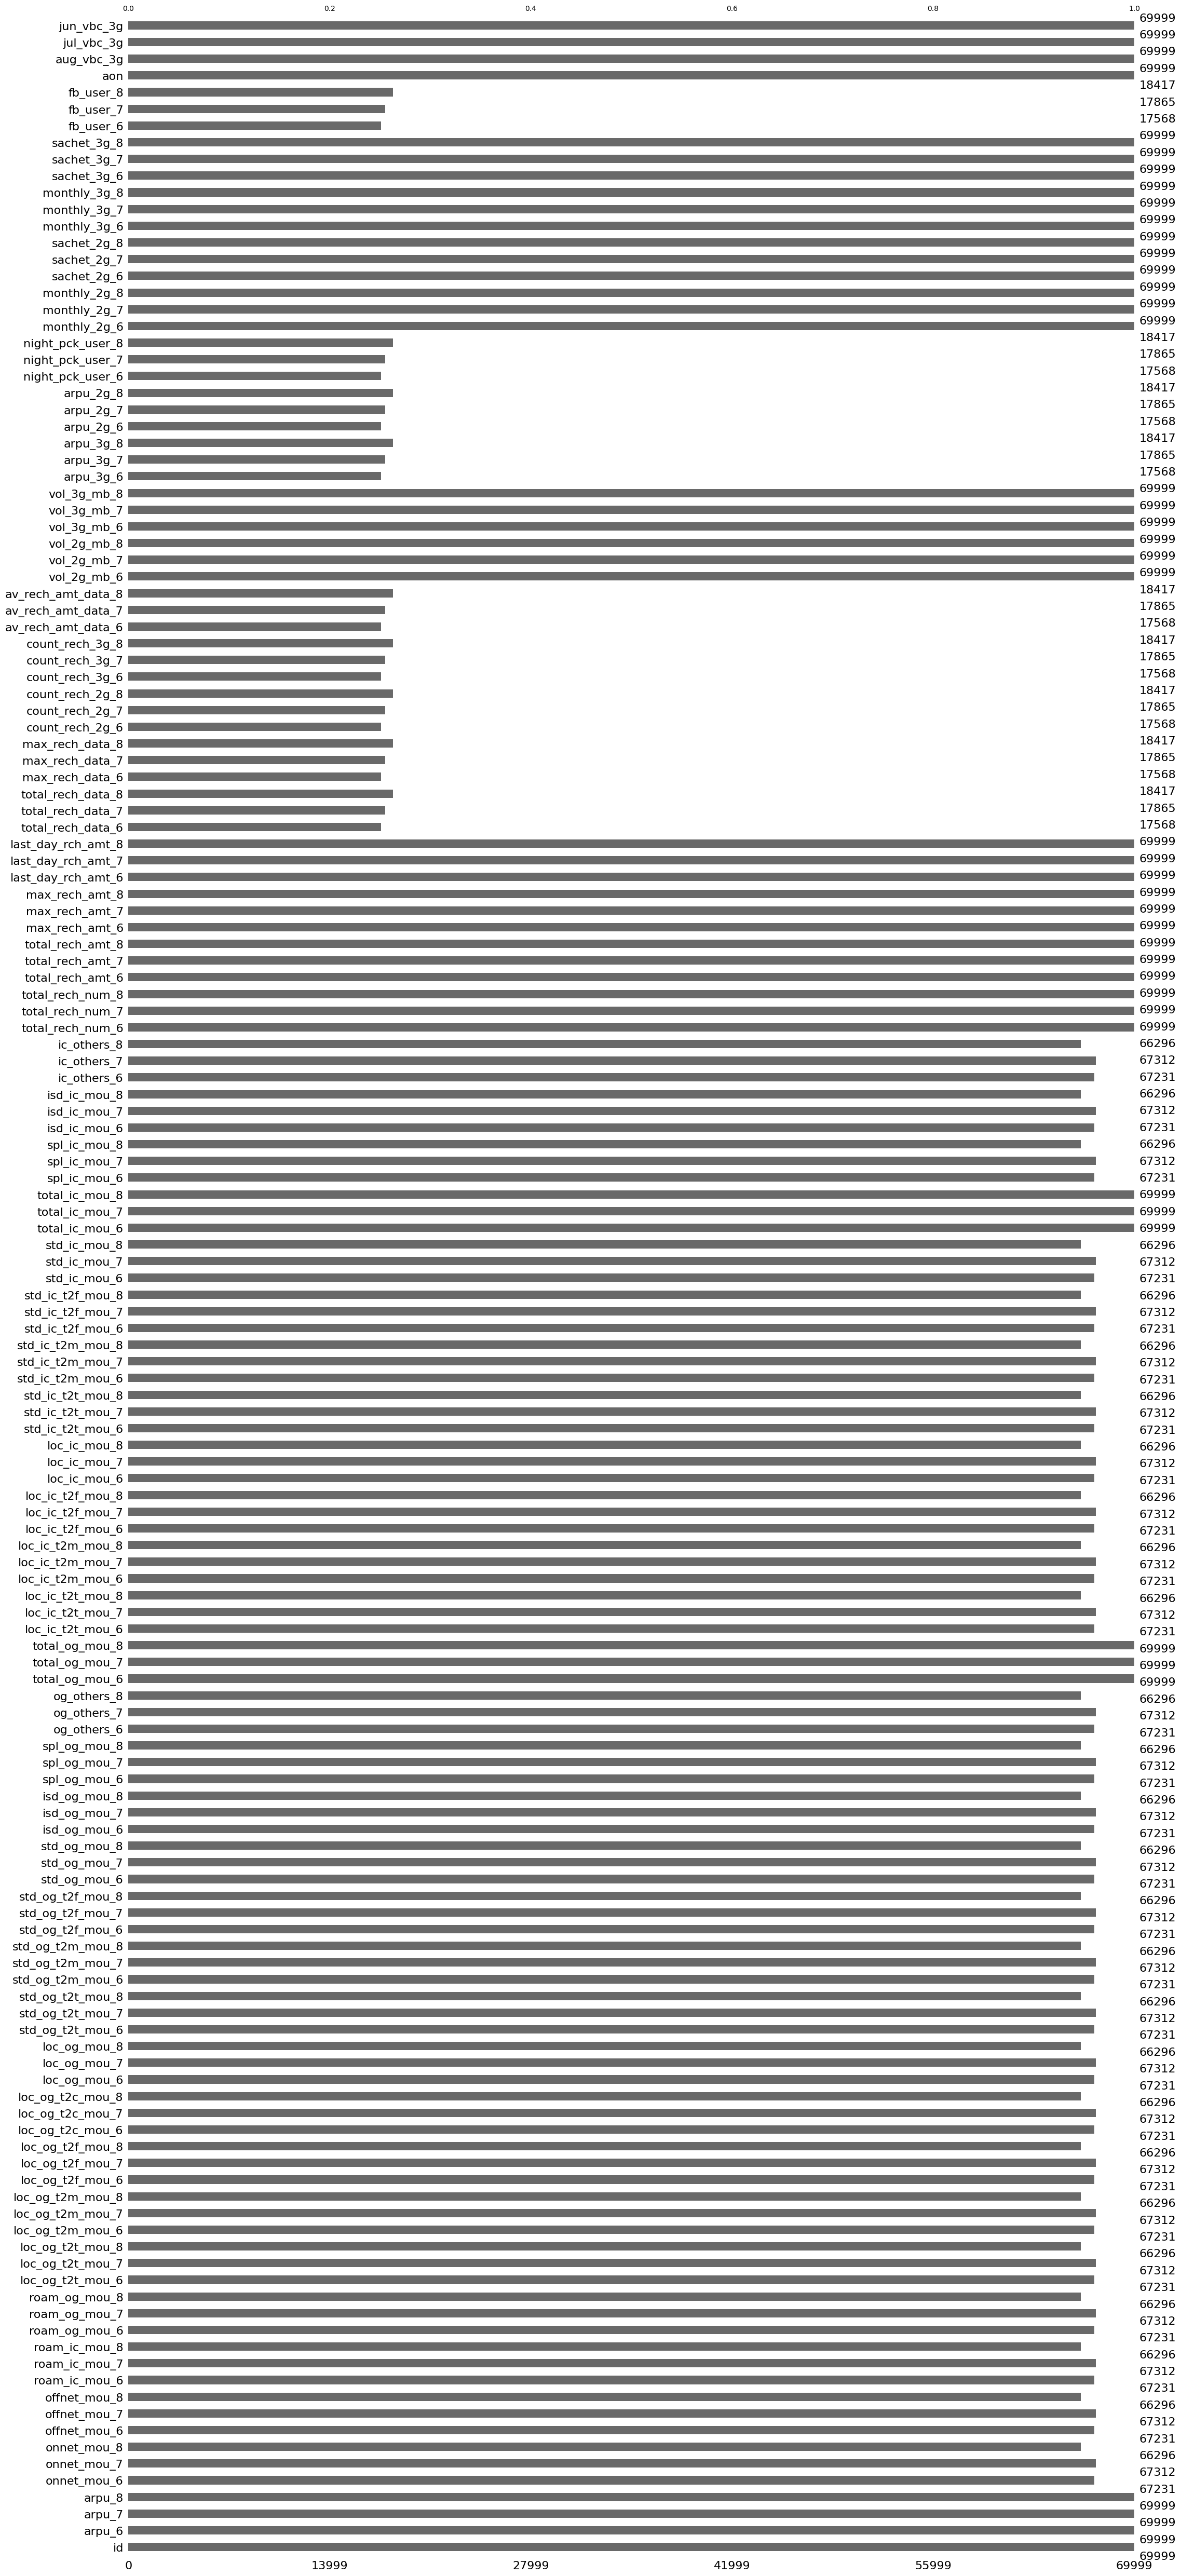

In [93]:
msno.bar(X)

In [94]:
missing_data_percent = 100*X.isnull().sum()/len(X)
missing_data_percent

id              0.000000
arpu_6          0.000000
arpu_7          0.000000
arpu_8          0.000000
onnet_mou_6     3.954342
                 ...    
fb_user_8      73.689624
aon             0.000000
aug_vbc_3g      0.000000
jul_vbc_3g      0.000000
jun_vbc_3g      0.000000
Length: 152, dtype: float64

In [95]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=125)

In [96]:
X_filtered = X[new_vars]
X_filtered.shape

(69999, 125)

In [97]:
print(X_filtered.shape)
print(y.shape)


(69999, 125)
(69999,)


In [98]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 125)
Shape of y: (69999,)


## 2.2 Deriving New Feature Columns 

We noticed that while there are a series of colulmns related to the same type of variable, there is no variable which explains the percentage increase or decrese over that time period. Consequentlyh we are proposing to add a few new columns for 

- Average change in revenue per user across months 6,7,8 (arpu_6, arpu_7, arpu_8)
- Average change in all kinds of calls within the same operator network for months 6,7,8 (onnet_mou_6, onnet_mou_7, onnet_mou_8)
- Average change in all kinds of calls outside the same operator network for months 6,7,8 (offnet_mou_6, offnet_mou_7, offnet_mou_8)




### Deriving new columns for average changes in revenue across months 6,7,8 (arpu_6, arpu_7, arpu_8)
Calculate the change in revenue between months:

From month 6 to month 7 (arpu_7 - arpu_6)
From month 7 to month 8 (arpu_8 - arpu_7)
Take the average of these two changes to create a new derived col


In [99]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 125)
Shape of y: (69999,)


In [100]:
# Calculate the average absolute change in revenue
X_filtered['avg_absolute_change_revenue'] = (
    (X_filtered['arpu_7'] - X_filtered['arpu_6']) +
    (X_filtered['arpu_8'] - X_filtered['arpu_7'])
) / 2

# Calculate the average percentage change in revenue
X_filtered['avg_percentage_change_revenue'] = (
    ((X_filtered['arpu_7'] - X_filtered['arpu_6']) / X_filtered['arpu_6']) +
    ((X_filtered['arpu_8'] - X_filtered['arpu_7']) / X_filtered['arpu_7'])
) / 2


In [101]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 127)
Shape of y: (69999,)


In [102]:
X_filtered[['avg_absolute_change_revenue', 'avg_percentage_change_revenue']].describe()


avg_absolute_change_revenue  avg_percentage_change_revenue
count                 69999.000000                   6.837700e+04
mean                     -2.137769                            NaN
std                     145.127104                            NaN
min                   -5752.754000                           -inf
25%                     -51.805750                  -1.427237e-01
50%                      -0.732000                   9.301916e-02
75%                      47.756250                   5.329413e-01
max                    6804.332000                            inf

In [103]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 127)
Shape of y: (69999,)


In [104]:
# # Replace inf, -inf, and NaN with NaN (for consistency)
# X_filtered['avg_percentage_change_revenue'] = X_train_filtered['avg_percentage_change_revenue'].replace([float('inf'), -float('inf')], float('nan'))

# # Drop rows with NaN in avg_percentage_change_revenue
# X_filtered = X_filtered.dropna(subset=['avg_percentage_change_revenue'])

# Recompute the mean and describe
print(X_filtered['avg_percentage_change_revenue'].mean())
print(X_filtered[['avg_absolute_change_revenue', 'avg_percentage_change_revenue']].describe())


nan
       avg_absolute_change_revenue  avg_percentage_change_revenue
count                 69999.000000                   6.837700e+04
mean                     -2.137769                            NaN
std                     145.127104                            NaN
min                   -5752.754000                           -inf
25%                     -51.805750                  -1.427237e-01
50%                      -0.732000                   9.301916e-02
75%                      47.756250                   5.329413e-01
max                    6804.332000                            inf


In [105]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 127)
Shape of y: (69999,)


### Deriving a new column for average change in all kinds of calls within the same operator network 

In [106]:
X_filtered[['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']].describe()

onnet_mou_6   onnet_mou_7   onnet_mou_8
count  67231.000000  67312.000000  66296.000000
mean     133.153275    133.894438    132.978257
std      299.963093    311.277193    311.896596
min        0.000000      0.000000      0.000000
25%        7.410000      6.675000      6.410000
50%       34.110000     32.280000     32.100000
75%      119.390000    115.837500    115.060000
max     7376.710000   8157.780000  10752.560000

In [107]:
# Replace missing values with 0 or any other appropriate default
X_filtered[['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']] = \
    X_filtered[['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']].fillna(0)


In [108]:
# Calculate the average change in on-net minutes of usage
X_filtered['avg_change_onnet_mou'] = (
    (X_filtered['onnet_mou_7'] - X_filtered['onnet_mou_6']) +
    (X_filtered['onnet_mou_8'] - X_filtered['onnet_mou_7'])
) / 2


In [109]:
print(X_filtered['avg_change_onnet_mou'].describe())


count    69999.000000
mean        -0.972166
std        134.971400
min      -3411.600000
25%        -12.680000
50%          0.000000
75%         10.235000
max       3395.190000
Name: avg_change_onnet_mou, dtype: float64


In [110]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 128)
Shape of y: (69999,)


### Deriving a new column for average change in all kinds of calls outside the operator network 

In [111]:
X_filtered[['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']].describe()

offnet_mou_6  offnet_mou_7  offnet_mou_8
count  67231.000000  67312.000000  66296.000000
mean     198.874771    197.153383    196.543577
std      316.818355    322.482226    324.089234
min        0.000000      0.000000      0.000000
25%       34.860000     32.240000     31.575000
50%       96.480000     91.885000     91.800000
75%      232.990000    227.630000    229.345000
max     8362.360000   7043.980000  14007.340000

In [112]:
# Calculate the average change in off-net minutes of usage
X_filtered['avg_change_offnet_mou'] = (
    (X_filtered['offnet_mou_7'] - X_filtered['offnet_mou_6']) +
    (X_filtered['offnet_mou_8'] - X_filtered['offnet_mou_7'])
) / 2


In [113]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 129)
Shape of y: (69999,)


In [114]:
# Replace missing values with 0 or another appropriate value
X_filtered[['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']] = \
    X_filtered[['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']].fillna(0)


In [115]:
print(X_filtered['avg_change_offnet_mou'].describe())


count    63842.000000
mean        -1.165819
std        141.760274
min      -4166.000000
25%        -27.360000
50%         -0.520000
75%         23.388750
max       6887.525000
Name: avg_change_offnet_mou, dtype: float64


## 2.3 Train Test Split

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((55999, 129), (14000, 129), (55999,), (14000,))

In [117]:
X_train.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
20076  20076  473.317  407.620  412.986        88.76        49.96   
39494  39494  179.820  229.598  266.288        29.03        53.84   
22799  22799  438.080    0.000    0.000         0.00         0.00   
5085    5085  652.363  908.947  249.428         9.39         7.48   
26522  26522  878.094  261.054  306.899       122.36       203.66   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  \
20076       140.46        309.14        342.28        277.59  ...   
39494        71.71        249.54        135.71        160.09  ...   
22799         0.00          0.00          0.00          0.00  ...   
5085          2.06       1544.88       2135.74        507.61  ...   
26522       175.03       2040.31        369.64        479.61  ...   

       sachet_3g_7  sachet_3g_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
20076            0            0  1301         0.0         0.0         0.0   
39494            0            0  3110         0.0         0.0         0.0   
22799            0            0   925         0.0         0.0         0.0   
5085             0            0   222         0.0         0.0         0.0   
26522            0            0   667         0.0         0.0         0.0   

       avg_absolute_change_revenue  avg_percentage_change_revenue  \
20076                     -30.1655                      -0.062819   
39494                      43.2340                       0.218311   
22799                    -219.0400                            NaN   
5085                     -201.4675                      -0.166135   
26522                    -285.5975                      -0.263544   

       avg_change_onnet_mou  avg_change_offnet_mou  
20076                25.850                -15.775  
39494                21.340                -44.725  
22799                 0.000                    NaN  
5085                 -3.665               -518.635  
26522                26.335               -780.350  

[5 rows x 129 columns]

# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

## 3.1 Handling Missing data - Training Set

In [118]:
print(X_train.shape)
print(y_train.shape)


(55999, 129)
(55999,)


In [119]:
# Display the data types of each column
print(X_train.dtypes)


id                                 int64
arpu_6                           float64
arpu_7                           float64
arpu_8                           float64
onnet_mou_6                      float64
                                  ...   
jun_vbc_3g                       float64
avg_absolute_change_revenue      float64
avg_percentage_change_revenue    float64
avg_change_onnet_mou             float64
avg_change_offnet_mou            float64
Length: 129, dtype: object


In [120]:
# Select and print the data types of non-numeric columns
non_numeric_dtypes = X_train.select_dtypes(exclude=[np.number]).dtypes
print(non_numeric_dtypes)


Series([], dtype: object)


In [121]:
# Convert all columns to numeric, setting non-numeric values to NaN
X_train_filtered = X_train.apply(pd.to_numeric, errors='coerce')

In [122]:
print(X_train_filtered.shape)
print(y.shape)


(55999, 129)
(69999,)


<Axes: >

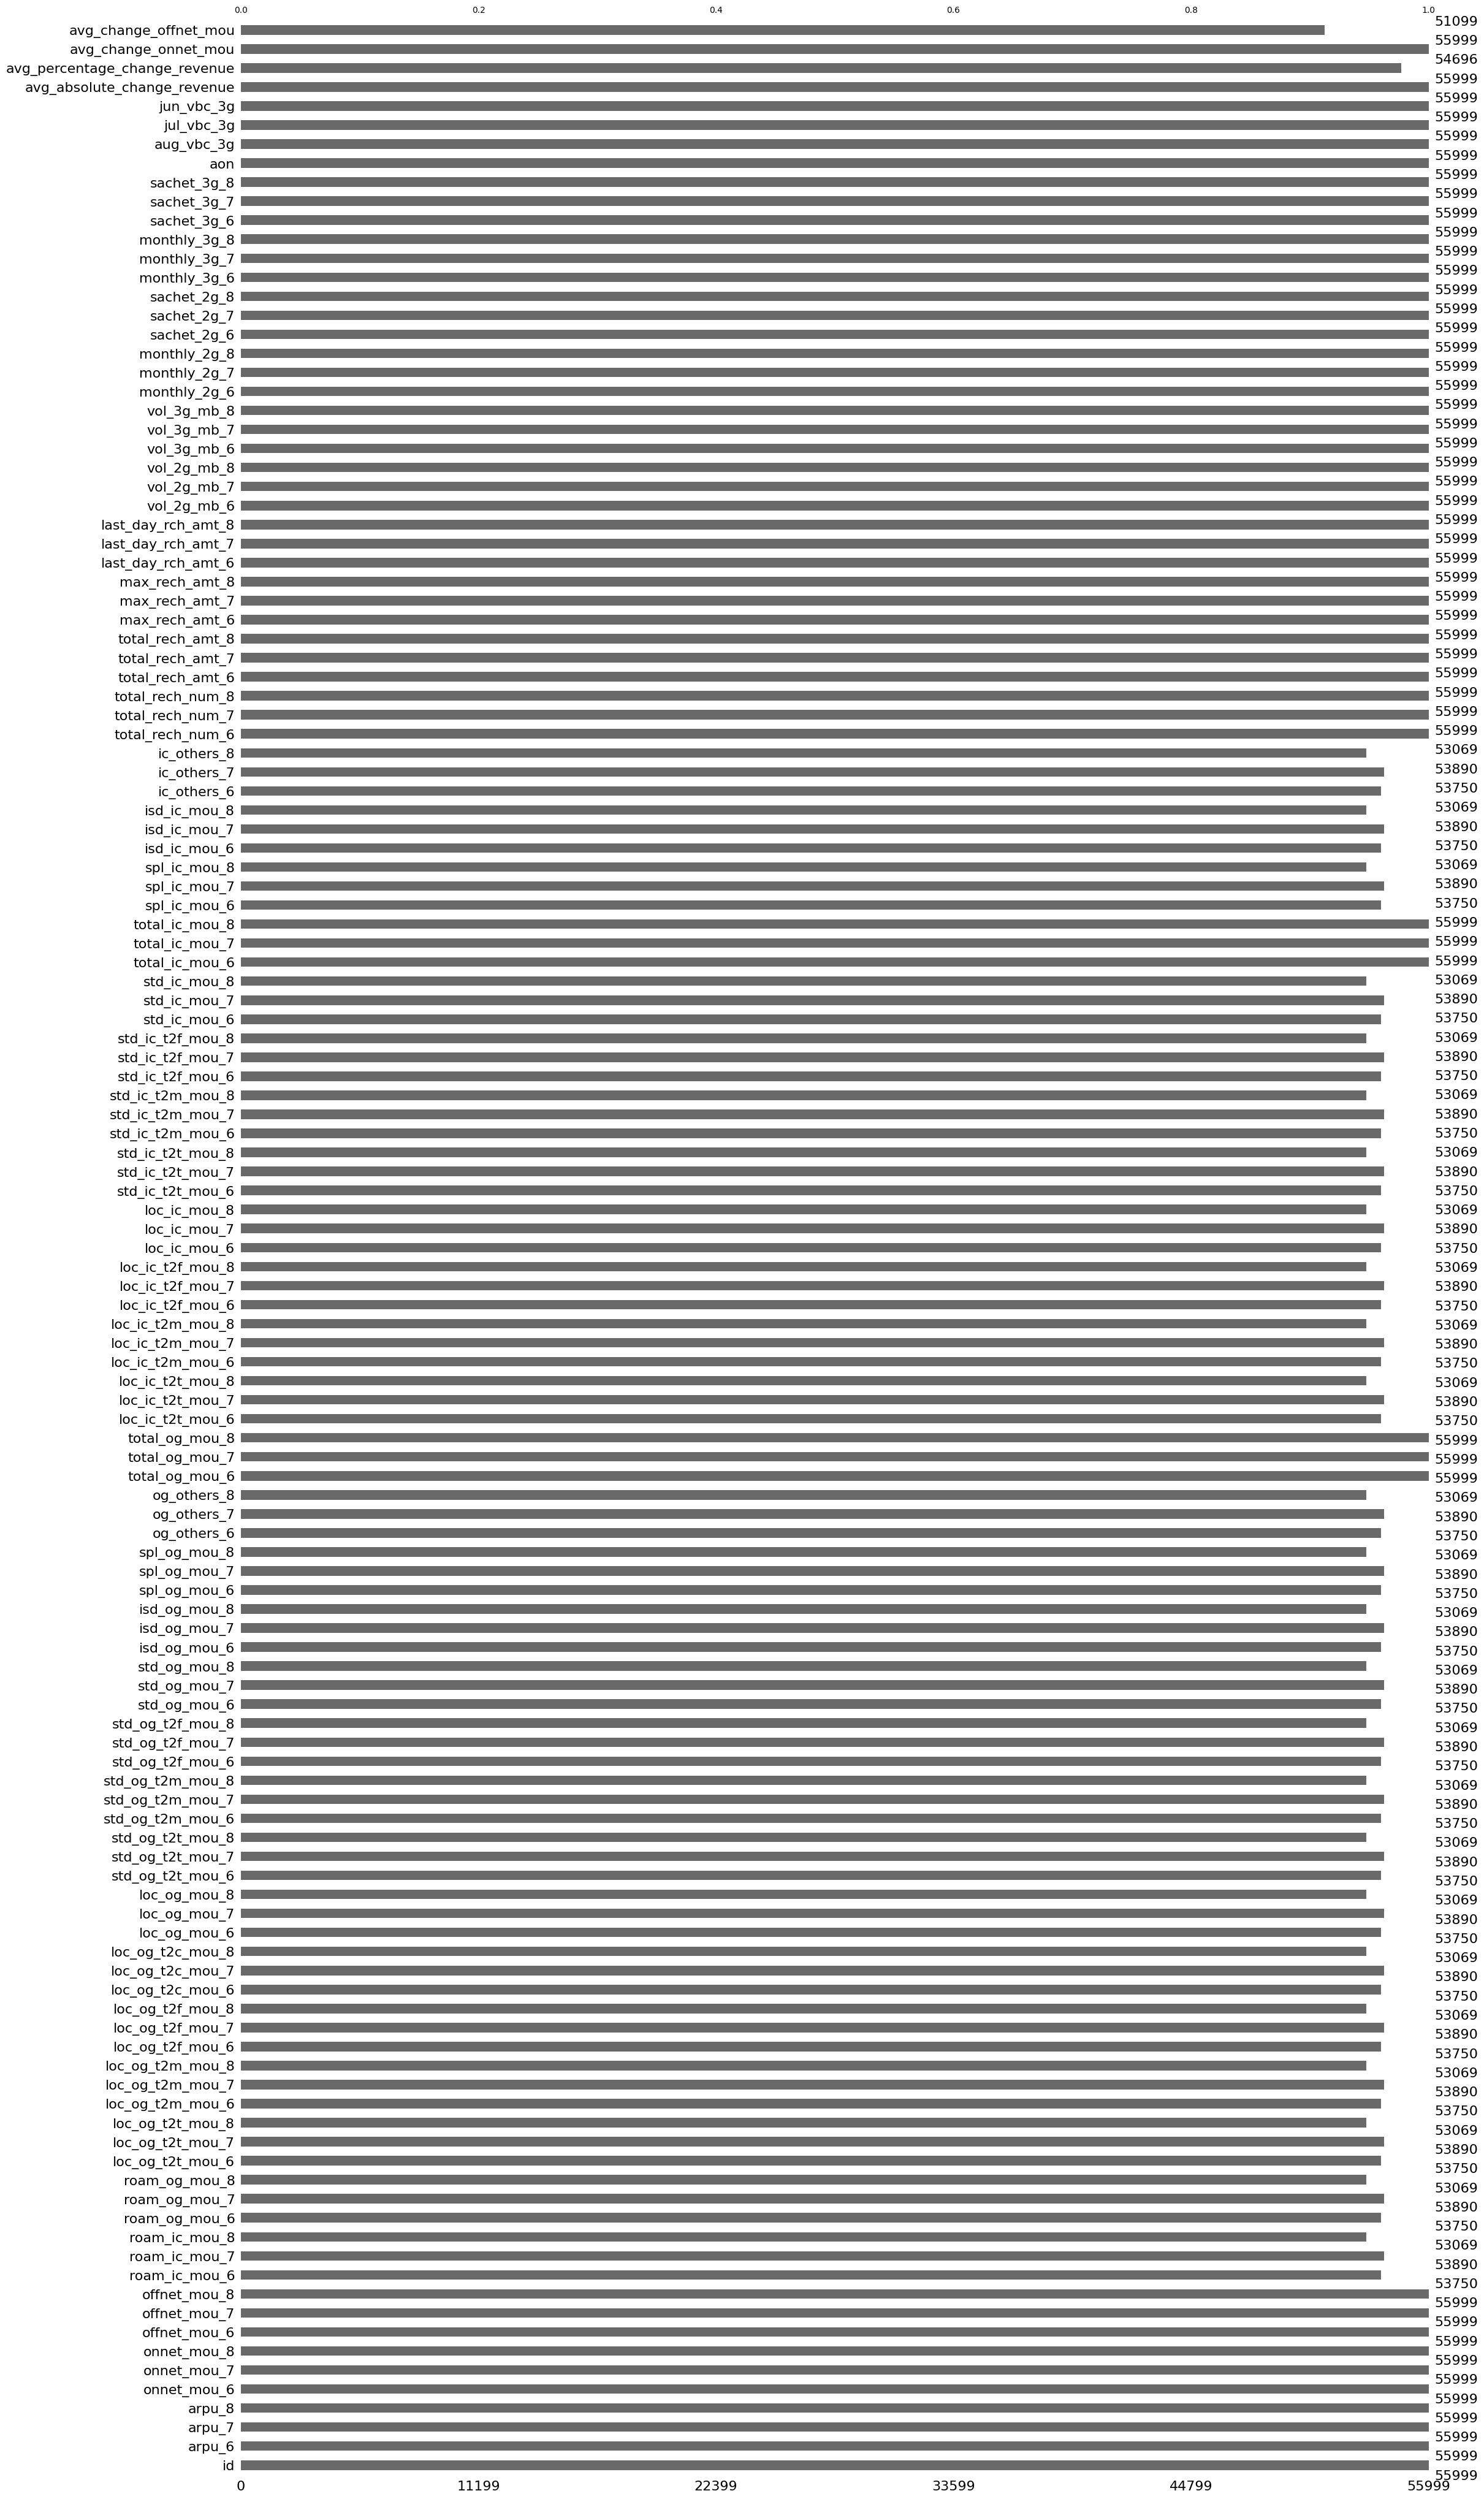

In [123]:
msno.bar(X_train)

In [124]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7',
       'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_

In [125]:
# Check for infinite values
print(np.isinf(X_train_filtered).sum())

# Check for very large values
print((X_train_filtered.abs() > 1e308).sum())


id                                  0
arpu_6                              0
arpu_7                              0
arpu_8                              0
onnet_mou_6                         0
                                 ... 
jun_vbc_3g                          0
avg_absolute_change_revenue         0
avg_percentage_change_revenue    2509
avg_change_onnet_mou                0
avg_change_offnet_mou               0
Length: 129, dtype: int64
id                                  0
arpu_6                              0
arpu_7                              0
arpu_8                              0
onnet_mou_6                         0
                                 ... 
jun_vbc_3g                          0
avg_absolute_change_revenue         0
avg_percentage_change_revenue    2509
avg_change_onnet_mou                0
avg_change_offnet_mou               0
Length: 129, dtype: int64


In [126]:
# Replace infinity with NaN
X_train_filtered['avg_percentage_change_revenue'] = X_train_filtered['avg_percentage_change_revenue'].replace([np.inf, -np.inf], np.nan)

# Calculate the median of the column
median_value = X_train_filtered['avg_percentage_change_revenue'].median()

# Replace NaN with the median value
X_train_filtered['avg_percentage_change_revenue'] = X_train_filtered['avg_percentage_change_revenue'].fillna(median_value)


In [127]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

<Axes: >

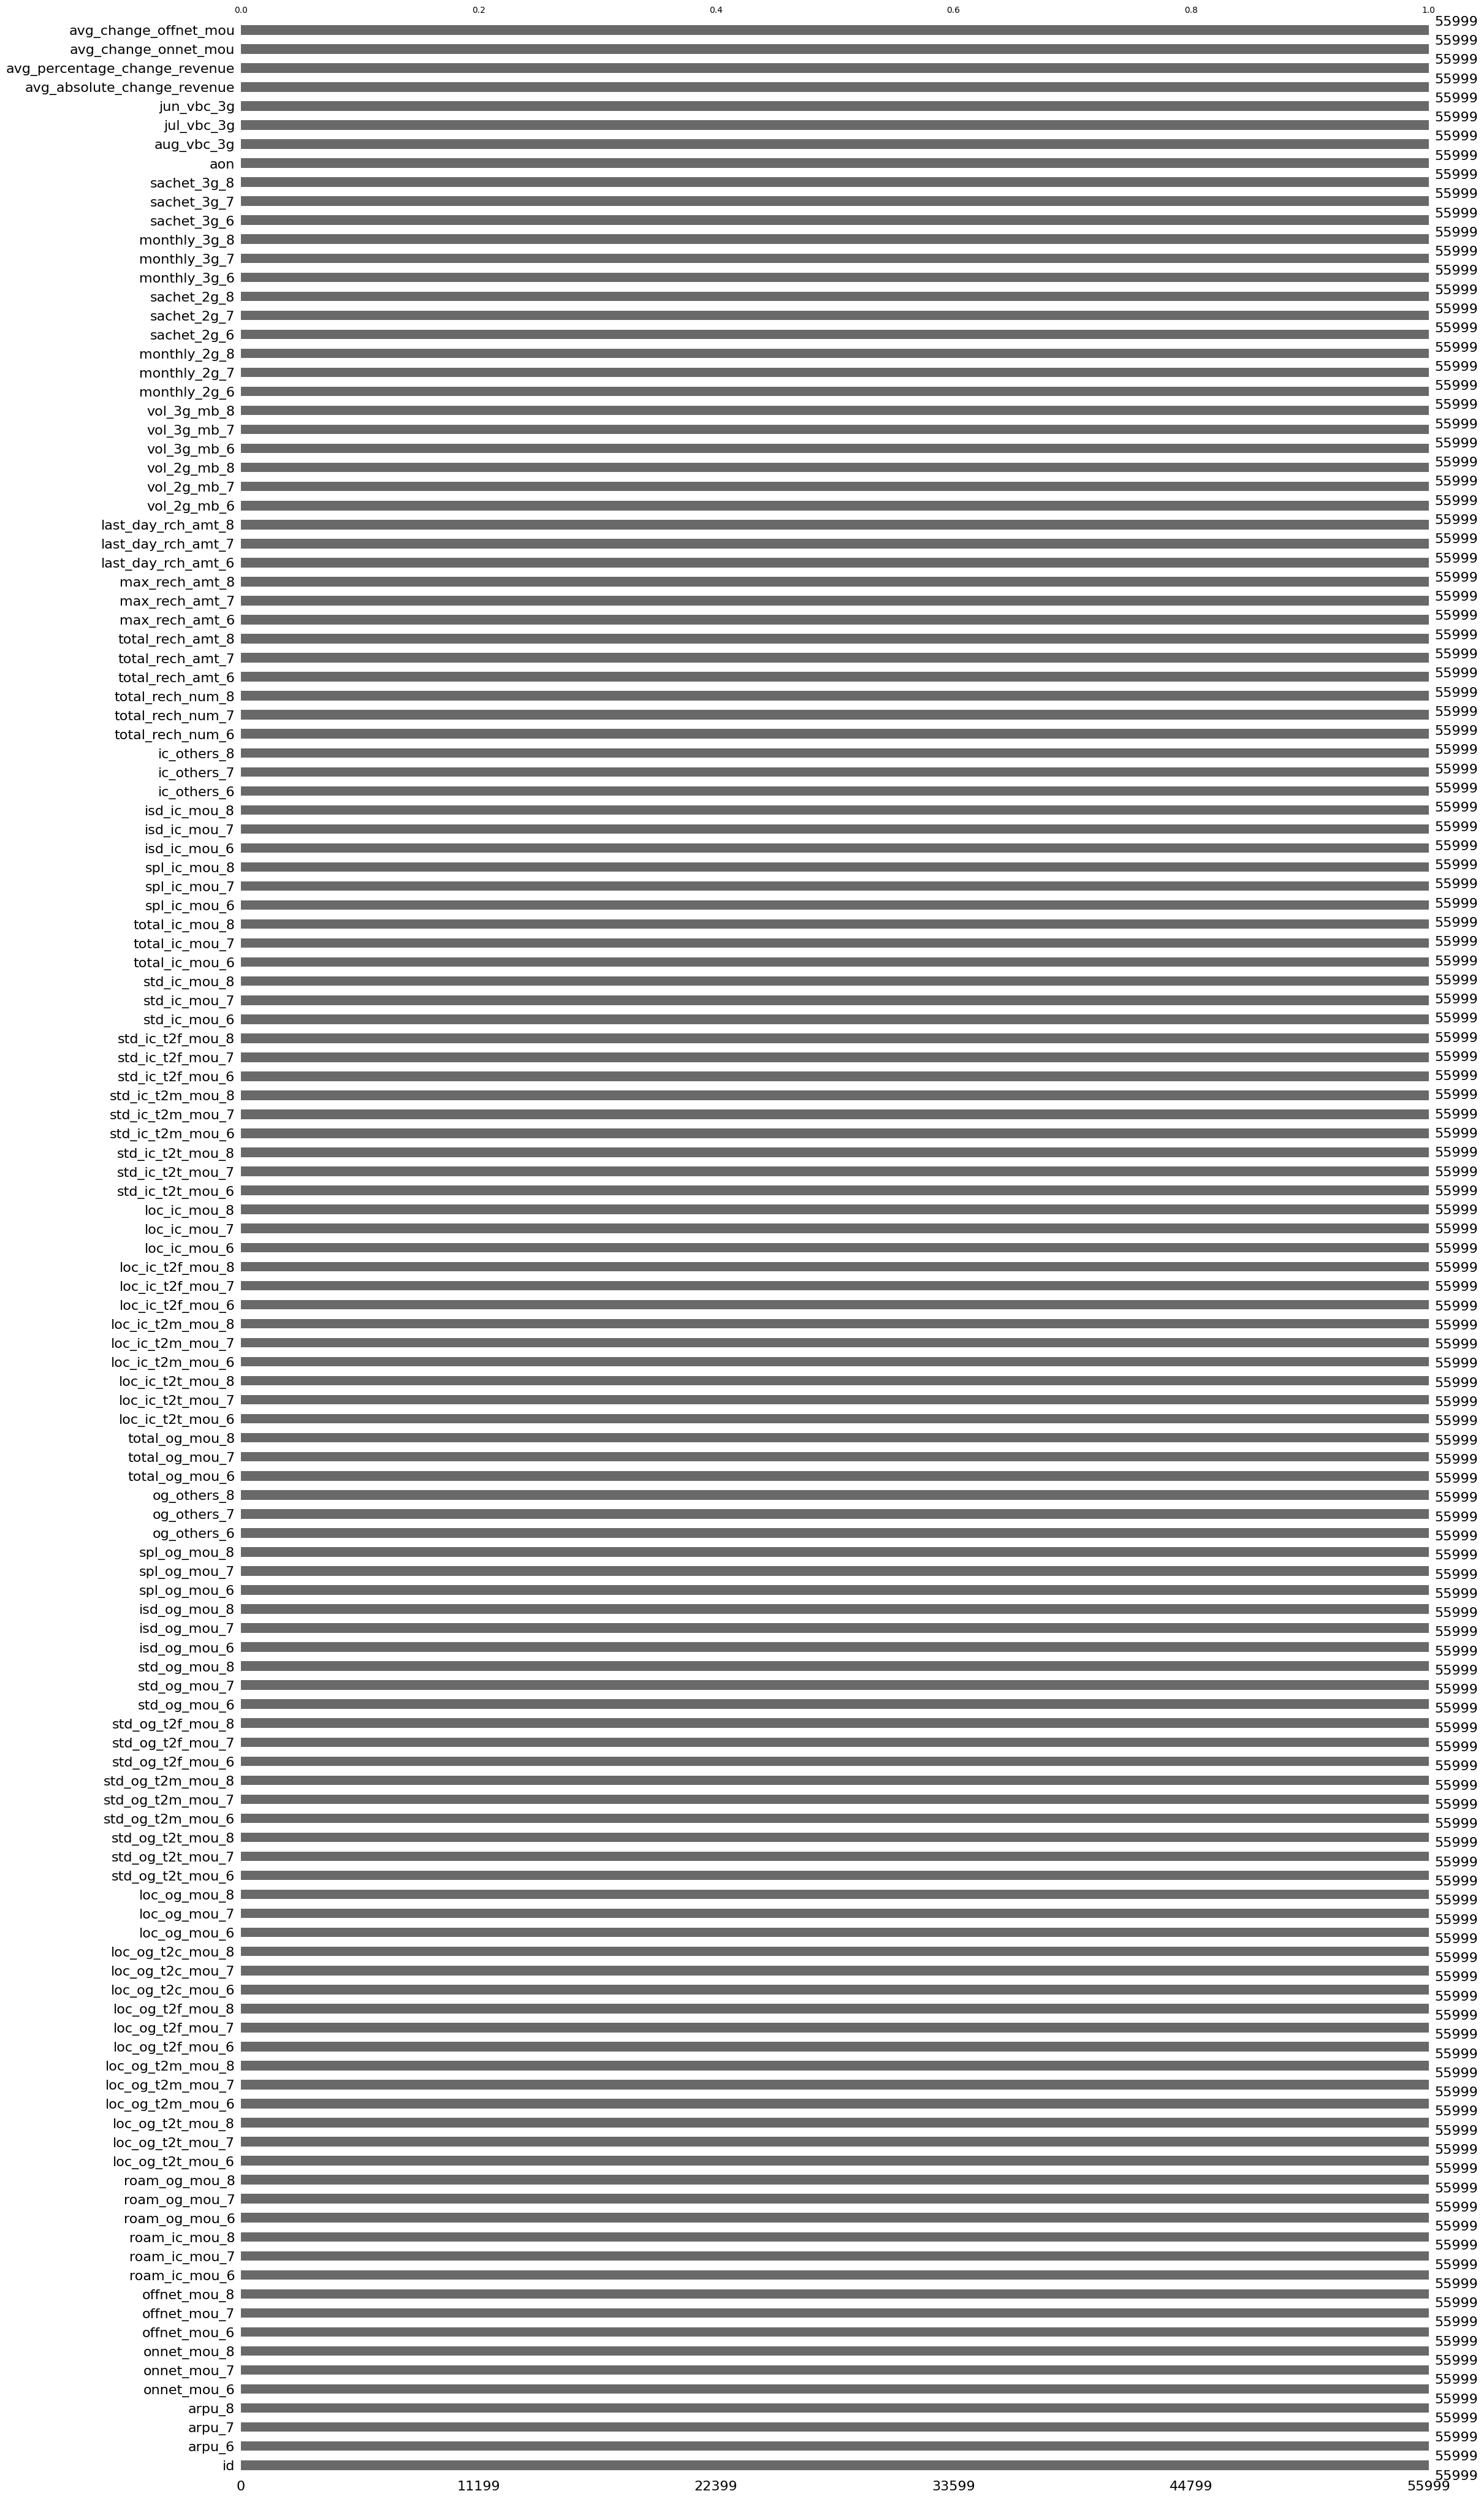

In [128]:
msno.bar(X_train_filtered)

In [129]:
print(X_train_filtered.shape)
print(y.shape)


(55999, 129)
(69999,)


In [130]:
X_train_filtered.describe()


id        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean   34993.619922    282.285436    277.730349    279.317885    127.839091   
std    20209.220985    312.236084    317.019242    328.489085    295.346336   
min        0.000000   -810.661000  -1289.715000   -345.129000      0.000000   
25%    17426.500000     93.451500     86.770500     84.461500      5.360000   
50%    35049.000000    197.140000    191.681000    192.829000     30.760000   
75%    52500.500000    370.202500    364.981500    370.450000    112.390000   
max    69998.000000  11261.349000  16820.145000  19295.904000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean     128.029377    125.967281    191.319747    190.194622    187.107916   
std      306.127979    306.925412    311.010027    316.678517    313.185495   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        4.940000      4.130000     28.710000     26.740000     23.780000   
50%       29.180000     27.830000     90.360000     86.010000     83.890000   
75%      107.835000    105.385000    224.770000    219.685000    217.980000   
max     8011.910000   9977.410000   8362.360000   7043.980000   7857.780000   

       ...   sachet_3g_7   sachet_3g_8           aon    aug_vbc_3g  \
count  ...  55999.000000  55999.000000  55999.000000  55999.000000   
mean   ...      0.084287      0.086073   1219.192861     67.717057   
std    ...      0.659532      0.682669    951.658569    266.887434   
min    ...      0.000000      0.000000    180.000000      0.000000   
25%    ...      0.000000      0.000000    467.500000      0.000000   
50%    ...      0.000000      0.000000    867.000000      0.000000   
75%    ...      0.000000      0.000000   1813.000000      0.000000   
max    ...     33.000000     41.000000   4321.000000  12916.220000   

         jul_vbc_3g    jun_vbc_3g  avg_absolute_change_revenue  \
count  55999.000000  55999.000000                 55999.000000   
mean      65.753550     59.911279                    -1.483776   
std      266.103329    259.498436                   144.209319   
min        0.000000      0.000000                 -4697.268000   
25%        0.000000      0.000000                   -51.398500   
50%        0.000000      0.000000                    -0.372500   
75%        0.000000      0.000000                    48.363500   
max     8716.150000  11166.210000                  6804.332000   

       avg_percentage_change_revenue  avg_change_onnet_mou  \
count                   55999.000000          55999.000000   
mean                       11.109111             -0.935905   
std                       322.305580            137.105732   
min                     -7037.778051          -3411.600000   
25%                        -0.133938            -12.700000   
50%                         0.074448              0.000000   
75%                         0.388704             10.125000   
max                     30174.501095           3395.190000   

       avg_change_offnet_mou  
count           55999.000000  
mean               -0.808662  
std               132.899498  
min             -4166.000000  
25%               -23.190000  
50%                 0.000000  
75%                19.637500  
max              2393.090000  

[8 rows x 129 columns]

## 3.2 Handling Missing data - Test Set

In [131]:
# Display the data types of each column
print(X_test.dtypes)

id                                 int64
arpu_6                           float64
arpu_7                           float64
arpu_8                           float64
onnet_mou_6                      float64
                                  ...   
jun_vbc_3g                       float64
avg_absolute_change_revenue      float64
avg_percentage_change_revenue    float64
avg_change_onnet_mou             float64
avg_change_offnet_mou            float64
Length: 129, dtype: object


In [132]:
# Select and print the data types of non-numeric columns
non_numeric_dtypes = X_test.select_dtypes(exclude=[np.number]).dtypes
print(non_numeric_dtypes)


Series([], dtype: object)


In [133]:
# Convert all columns to numeric, setting non-numeric values to NaN
X_test_filtered = X_test.apply(pd.to_numeric, errors='coerce')

<Axes: >

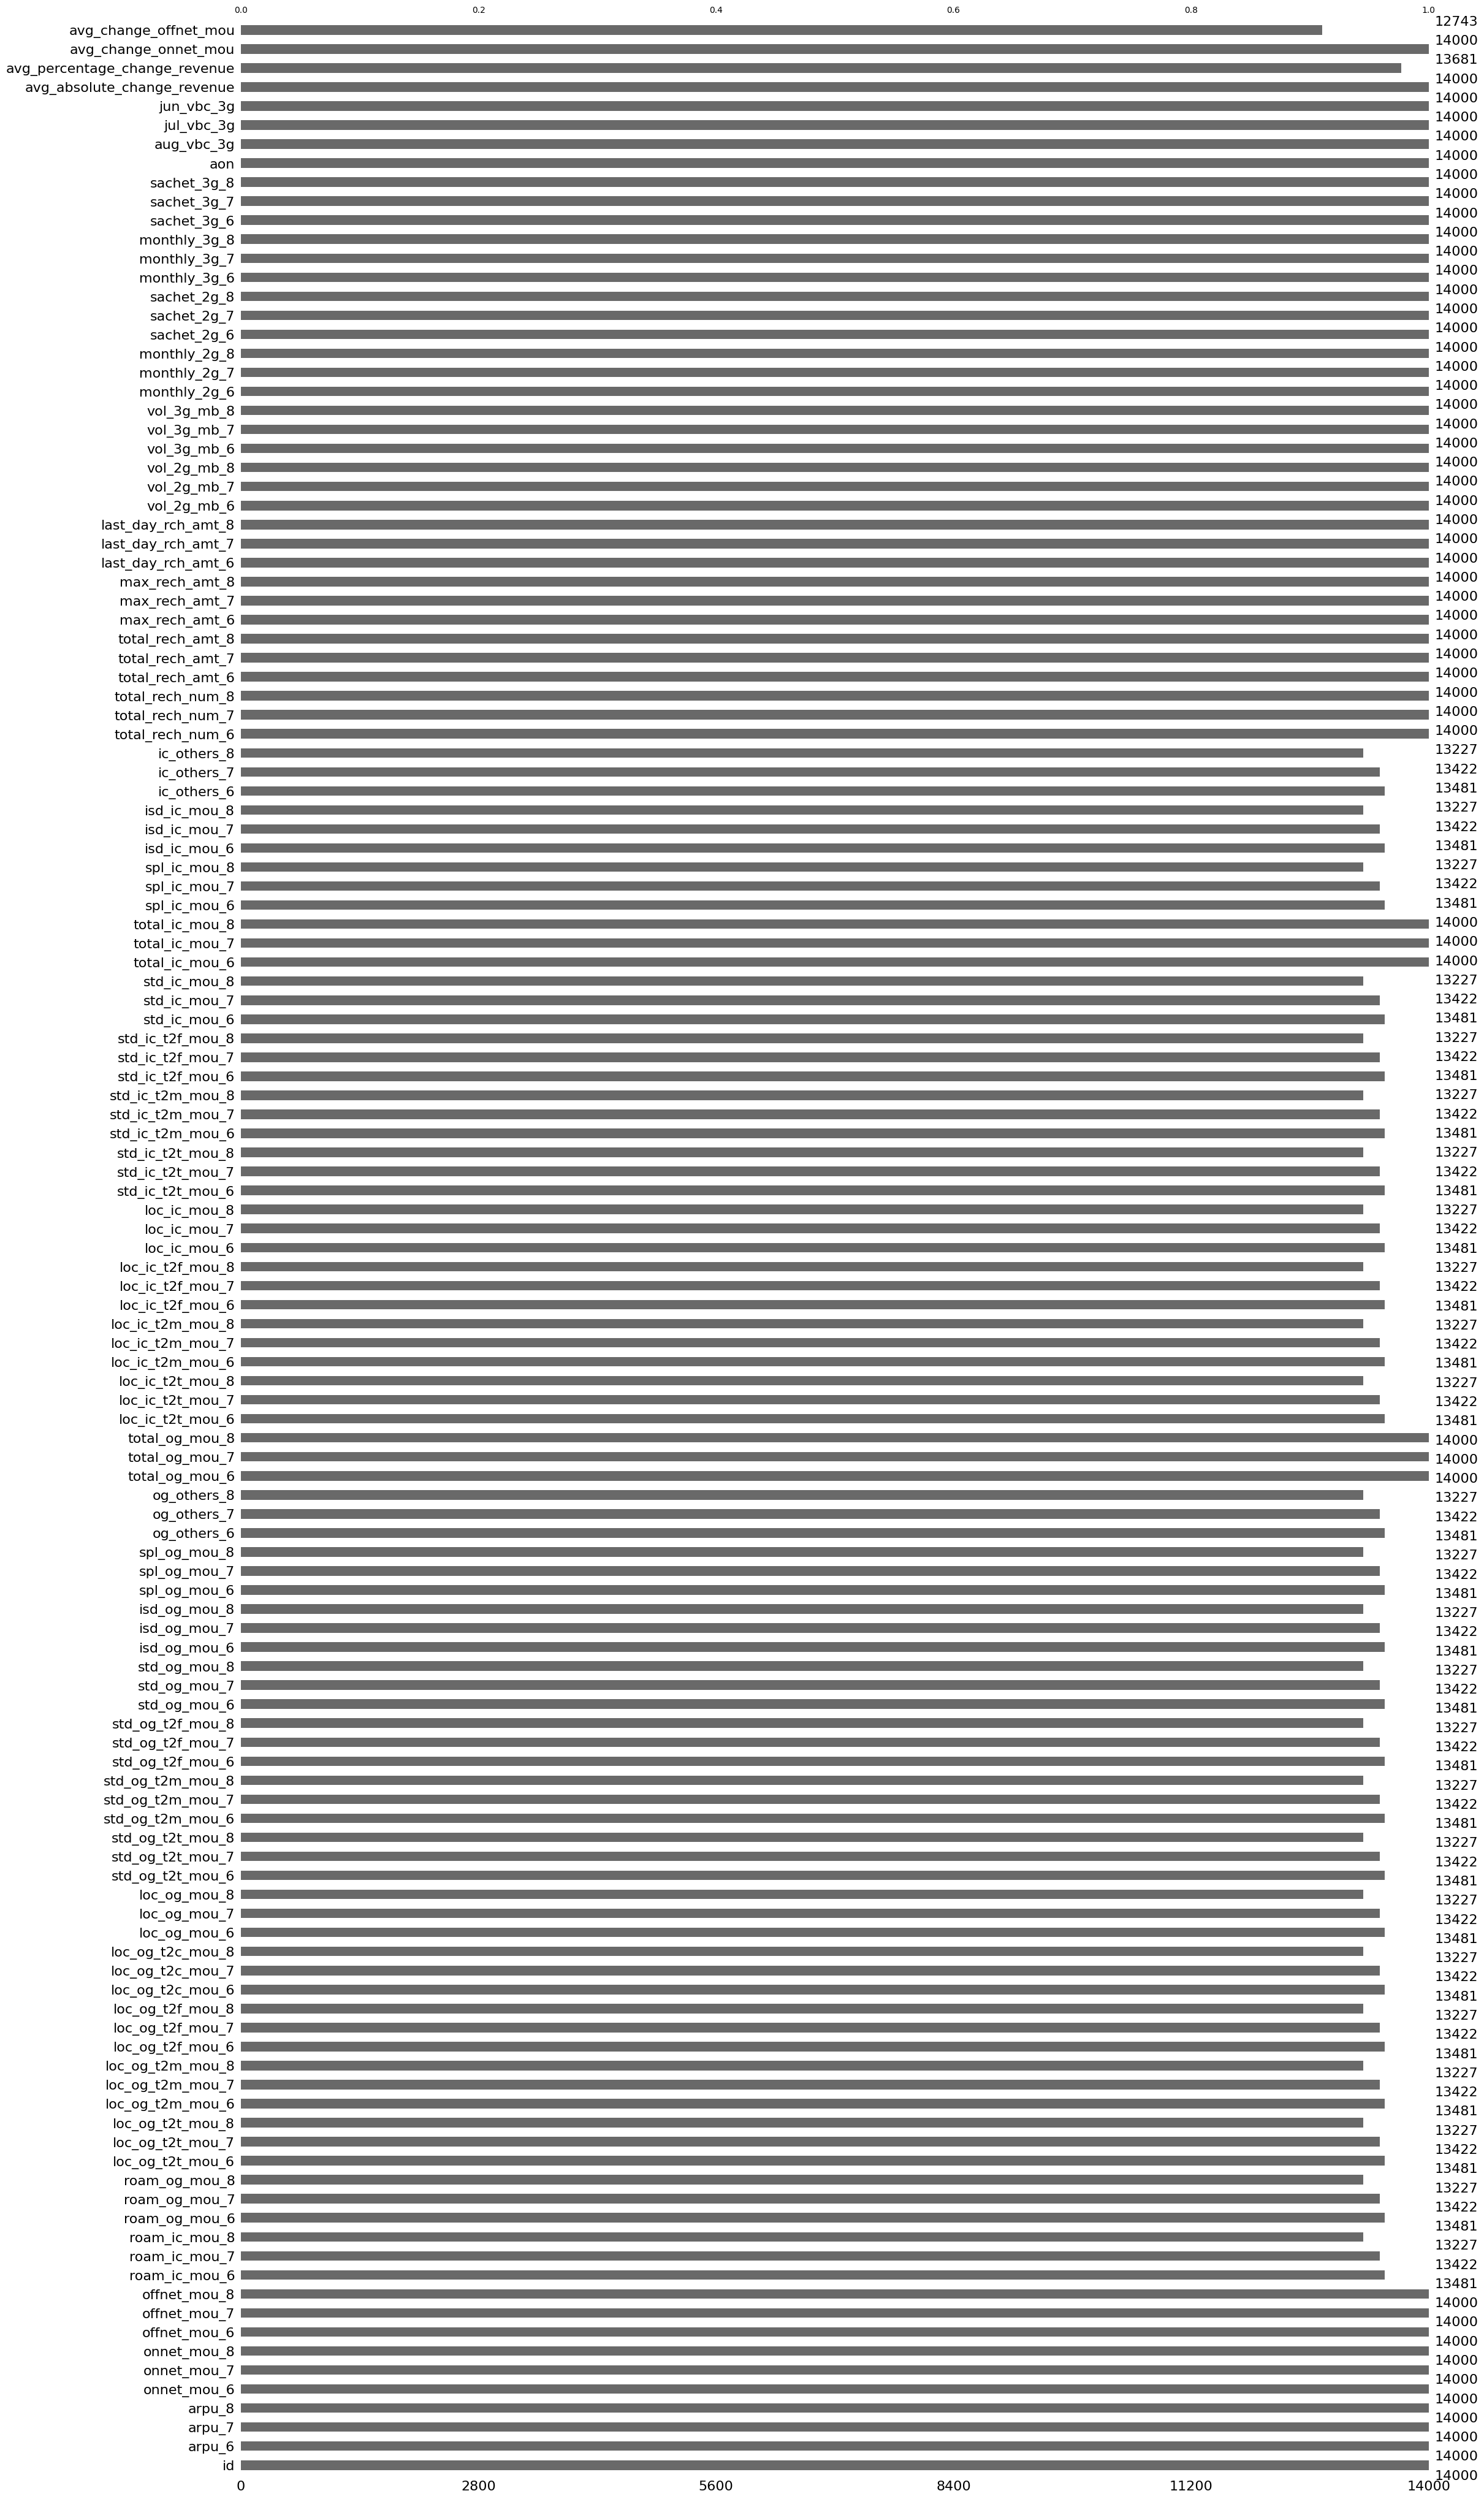

In [134]:
msno.bar(X_test)

In [135]:
missing_data_percent = X_test_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7',
       'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_

In [136]:
# Replace infinity with NaN
X_test_filtered['avg_percentage_change_revenue'] = X_test_filtered['avg_percentage_change_revenue'].replace([np.inf, -np.inf], np.nan)

# Calculate the median of the column
median_value = X_test_filtered['avg_percentage_change_revenue'].median()

# Replace NaN with the median value
X_test_filtered['avg_percentage_change_revenue'] = X_train_filtered['avg_percentage_change_revenue'].fillna(median_value)


In [137]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_test_filtered[impute_cols] = imp.fit_transform(X_test_filtered[impute_cols])

<Axes: >

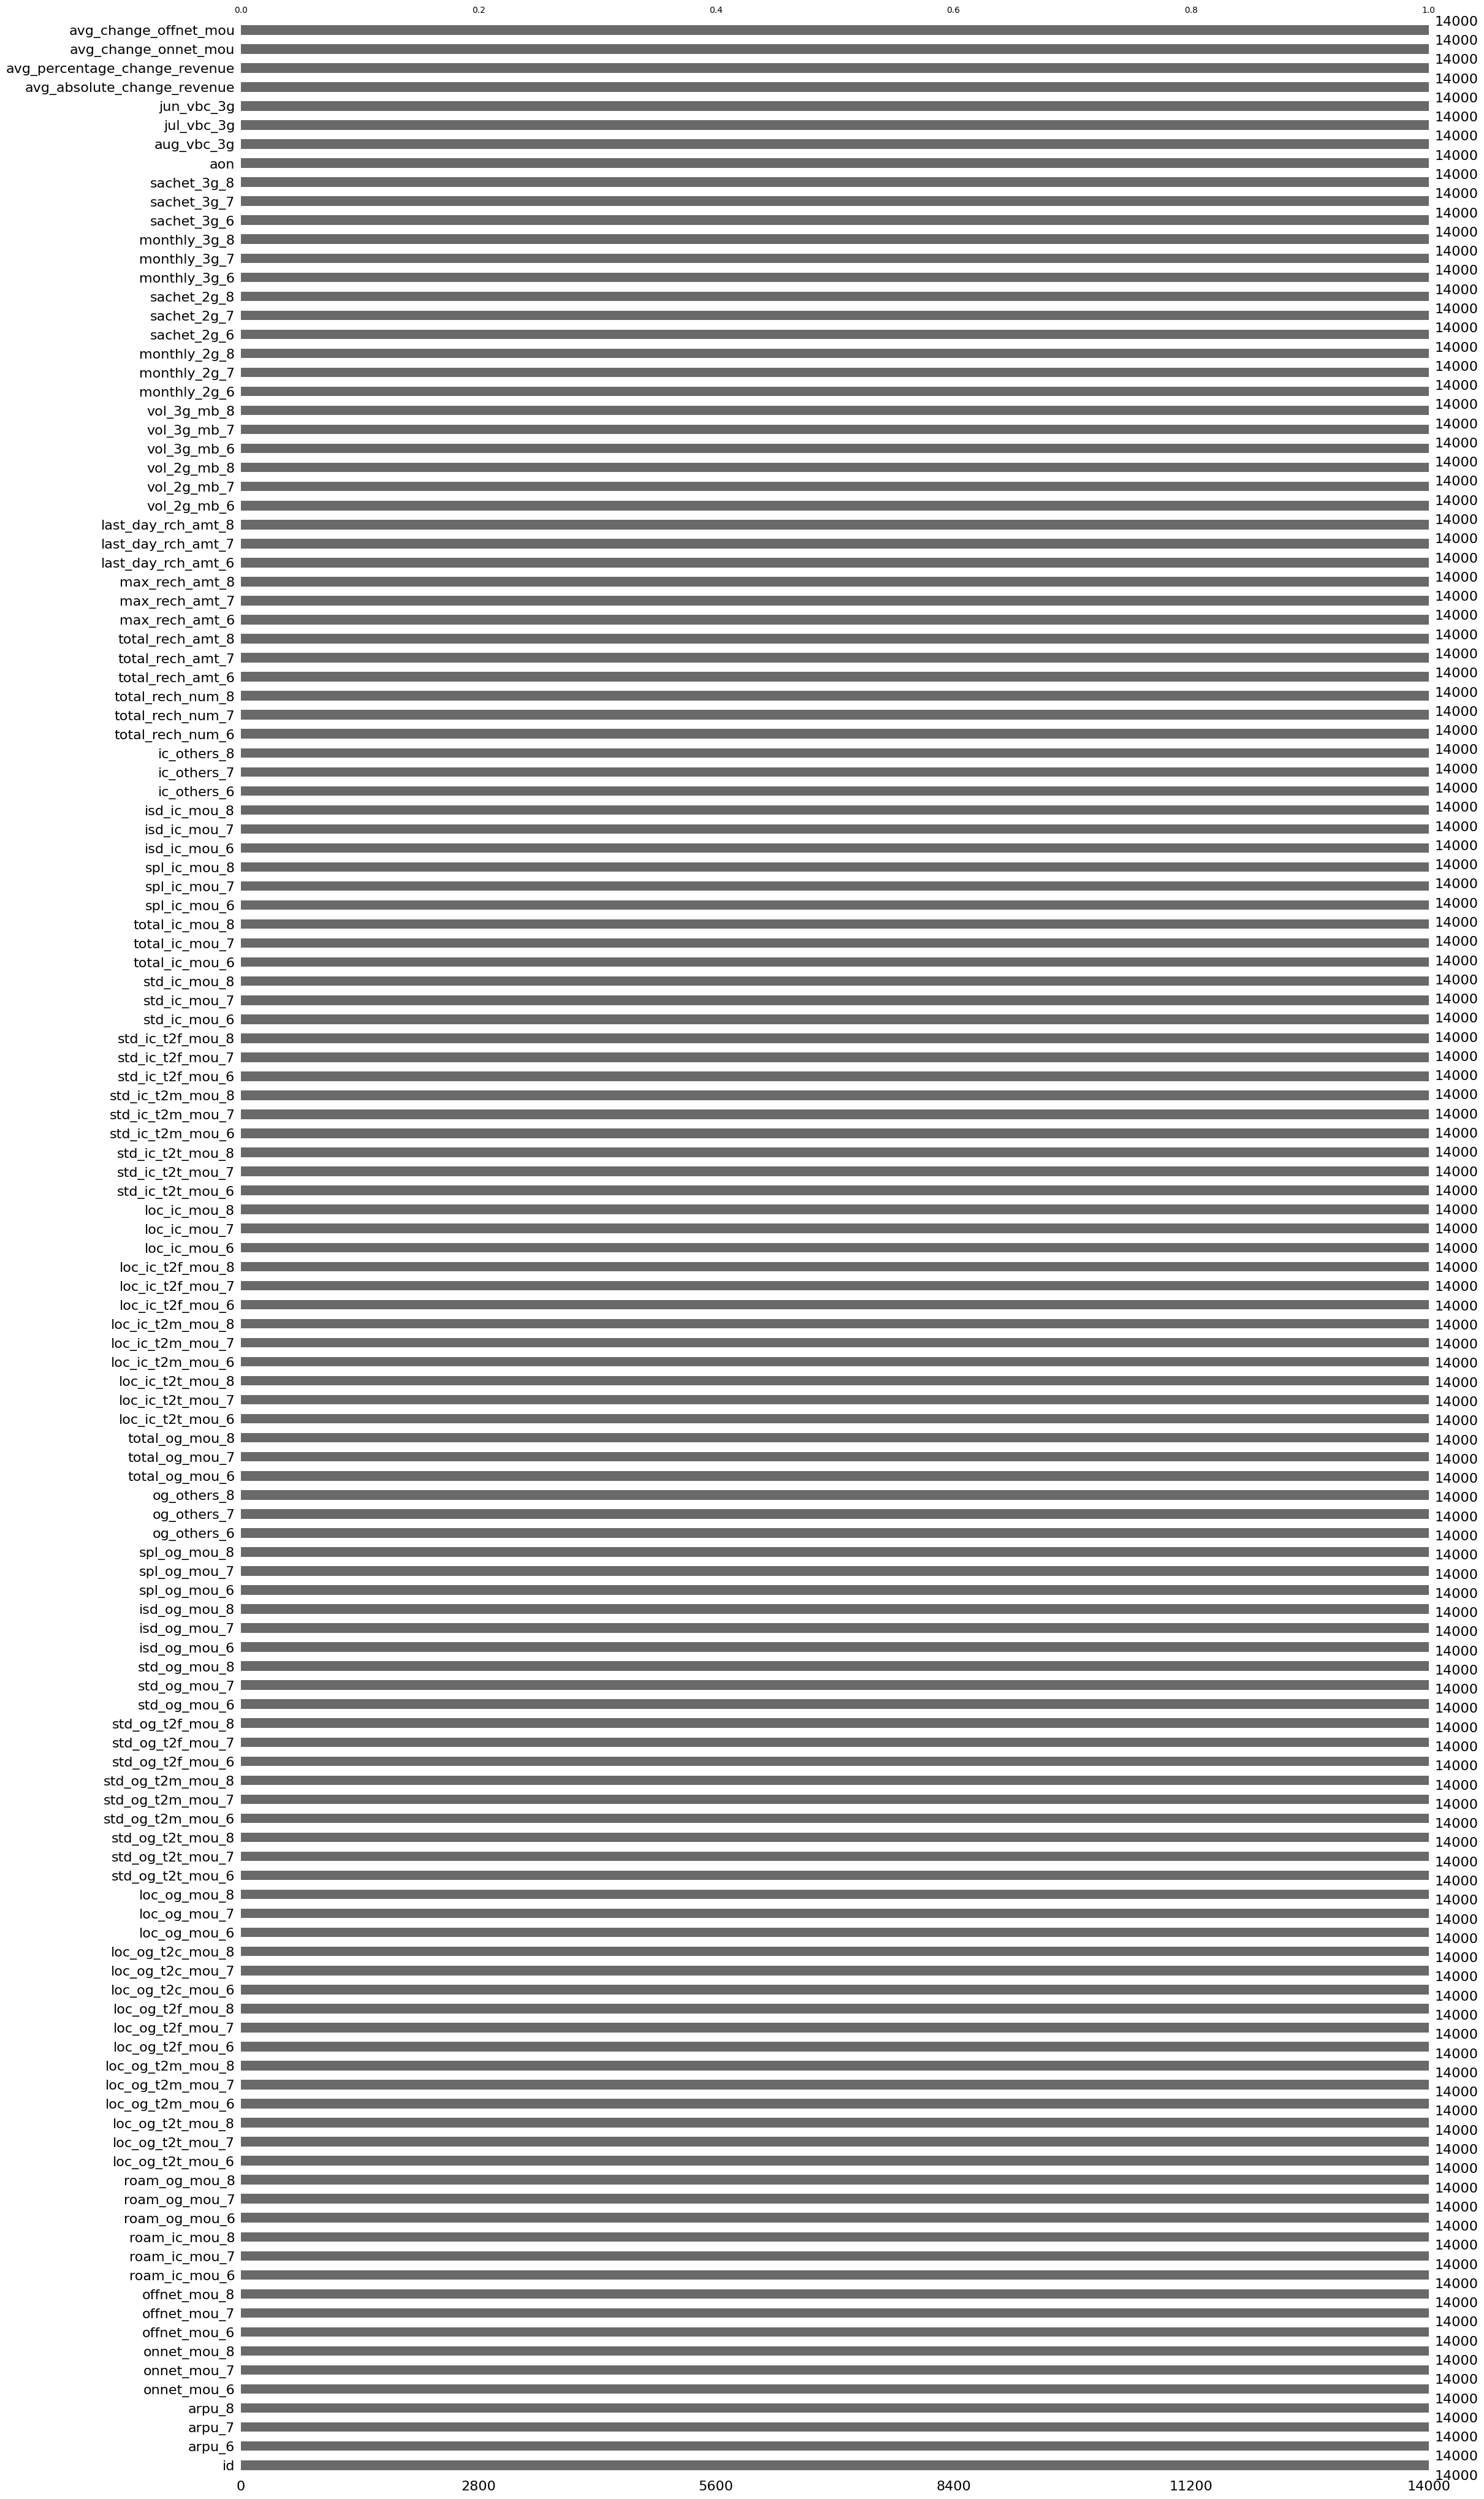

In [138]:
msno.bar(X_test_filtered)

# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

In [146]:
y_train.describe

<bound method NDFrame.describe of 20076    0
39494    0
22799    1
5085     0
26522    0
        ..
40743    0
66715    0
44975    0
5856     0
68881    0
Name: churn_probability, Length: 55999, dtype: int64>

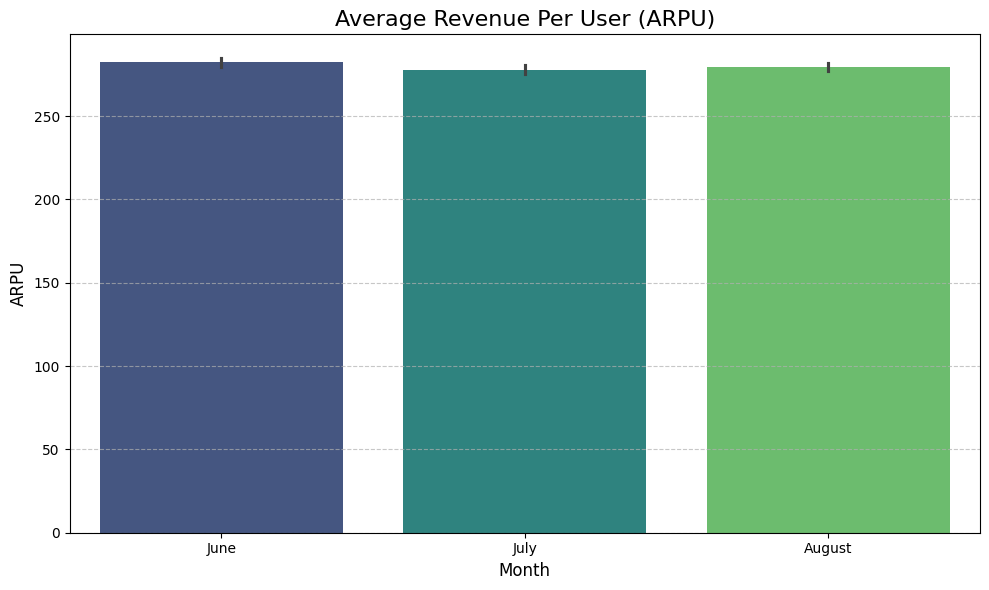

In [152]:
# Visualising Average Revenue per user
# Columns for ARPU
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8']
months = ['June', 'July', 'August']

# Prepare the DataFrame for plotting
arpu_data = X_train_filtered[arpu_cols].copy()
arpu_data.columns = months  # Rename columns for months

# Melt the DataFrame to long format
arpu_long = arpu_data.melt(var_name='Month', value_name='ARPU')

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=arpu_long, x='Month', y='ARPU', palette='viridis')

# Customize the plot
plt.title('Average Revenue Per User (ARPU)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('ARPU', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()





In [ ]:
# It appears that revenue is relatively stable month on month

### Visualising total outgoing minutes of usage

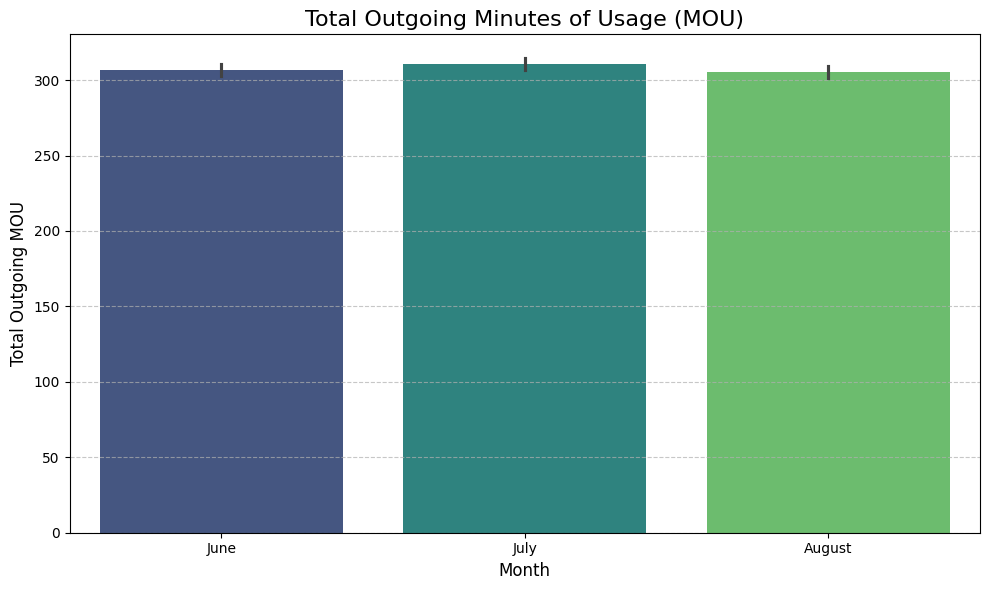

In [153]:
# Columns for total outgoing minutes of usage
total_og_mou_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
months = ['June', 'July', 'August']

# Prepare the DataFrame for plotting
mou_data = X_train_filtered[total_og_mou_cols].copy()
mou_data.columns = months  # Rename columns for months

# Melt the DataFrame to long format
mou_long = mou_data.melt(var_name='Month', value_name='Total Outgoing MOU')

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=mou_long, x='Month', y='Total Outgoing MOU', palette='viridis')

# Customize the plot
plt.title('Total Outgoing Minutes of Usage (MOU)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Outgoing MOU', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

Outgoing minutes of usage appears relatively stable

### Visualizing calls made outside the operator network

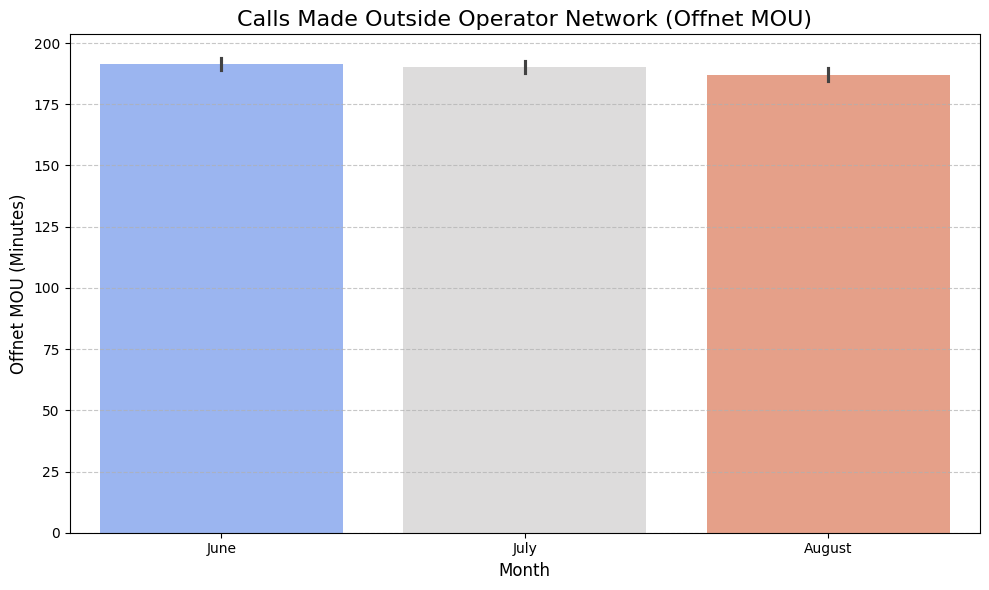

In [154]:
# Columns for calls made outside the operator network
offnet_mou_cols = ['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']
months = ['June', 'July', 'August']

# Prepare the DataFrame for plotting
offnet_data = X_train_filtered[offnet_mou_cols].copy()
offnet_data.columns = months  # Rename columns for months

# Melt the DataFrame to long format
offnet_long = offnet_data.melt(var_name='Month', value_name='Offnet MOU')

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=offnet_long, x='Month', y='Offnet MOU', palette='coolwarm')

# Customize the plot
plt.title('Calls Made Outside Operator Network (Offnet MOU)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Offnet MOU (Minutes)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# calls made outside the operator network appear relatively stable

### 4.3 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [61]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

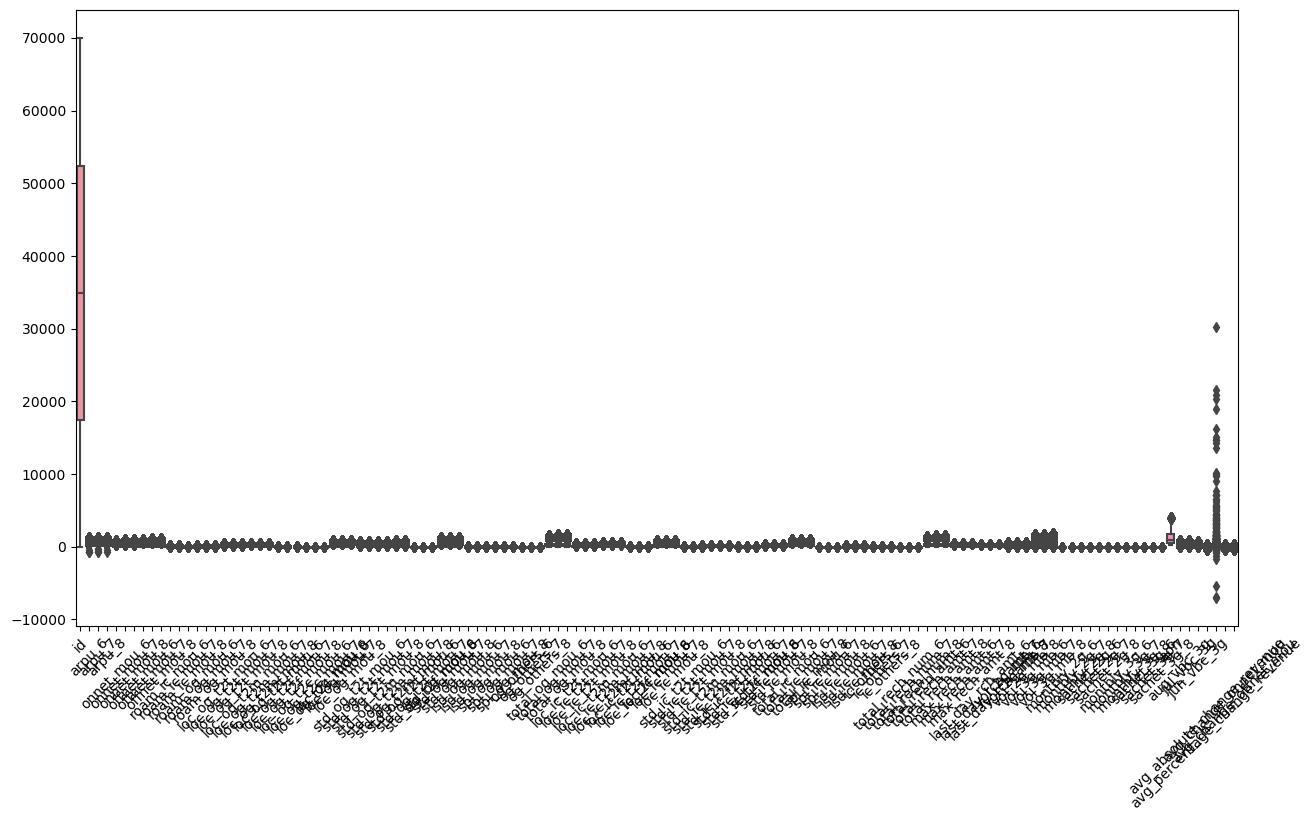

In [62]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

### 4.4 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [63]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [64]:
X_train_filtered1.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
25253  25253  142.185  107.279  115.470        59.14        66.31   
53819  53819  121.710    0.000    0.600        24.61         0.00   
21310  21310  107.033   77.565  206.757        28.41        76.69   
56535  56535  121.689  106.242  139.228       112.36       140.01   
36989  36989  256.339  217.296  120.339       104.34        60.31   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  \
25253        82.78         35.44         21.89         22.93  ...   
53819         1.01         37.48          0.00          0.00  ...   
21310       169.48        102.41         97.79        316.71  ...   
56535       112.98         26.79         20.76         15.93  ...   
36989        38.44        125.11        130.18         68.21  ...   

       sachet_3g_7  sachet_3g_8     aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
25253          0.0          0.0  2103.0         0.0         0.0         0.0   
53819          0.0          0.0   496.0         0.0         0.0         0.0   
21310          0.0          0.0  1072.0         0.0         0.0         0.0   
56535          0.0          0.0  2684.0         0.0         0.0         0.0   
36989          0.0          0.0  1496.0         0.0         0.0         0.0   

       avg_absolute_change_revenue  avg_percentage_change_revenue  \
25253                     -13.3575                      -0.084572   
53819                     -60.5550                            inf   
21310                      49.8620                       0.695140   
56535                       8.7695                       0.091771   
36989                     -68.0000                      -0.299254   

       avg_change_onnet_mou  avg_change_offnet_mou  
25253                11.820                 -6.255  
53819               -11.800                    NaN  
21310                70.535                107.150  
56535                 0.310                 -5.430  
36989               -32.950                -28.450  

[5 rows x 129 columns]

NameError: name 'X_train_filtered2' is not defined

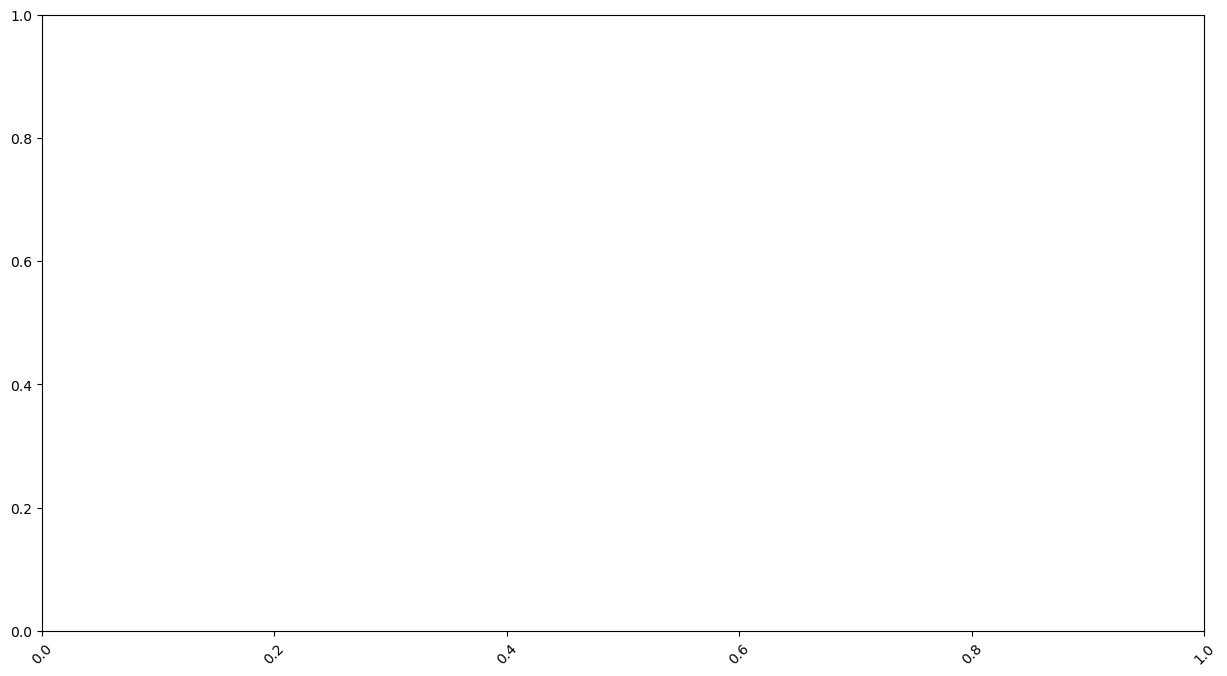

In [65]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2))

In [66]:
updated_cols = X_train_filtered.columns


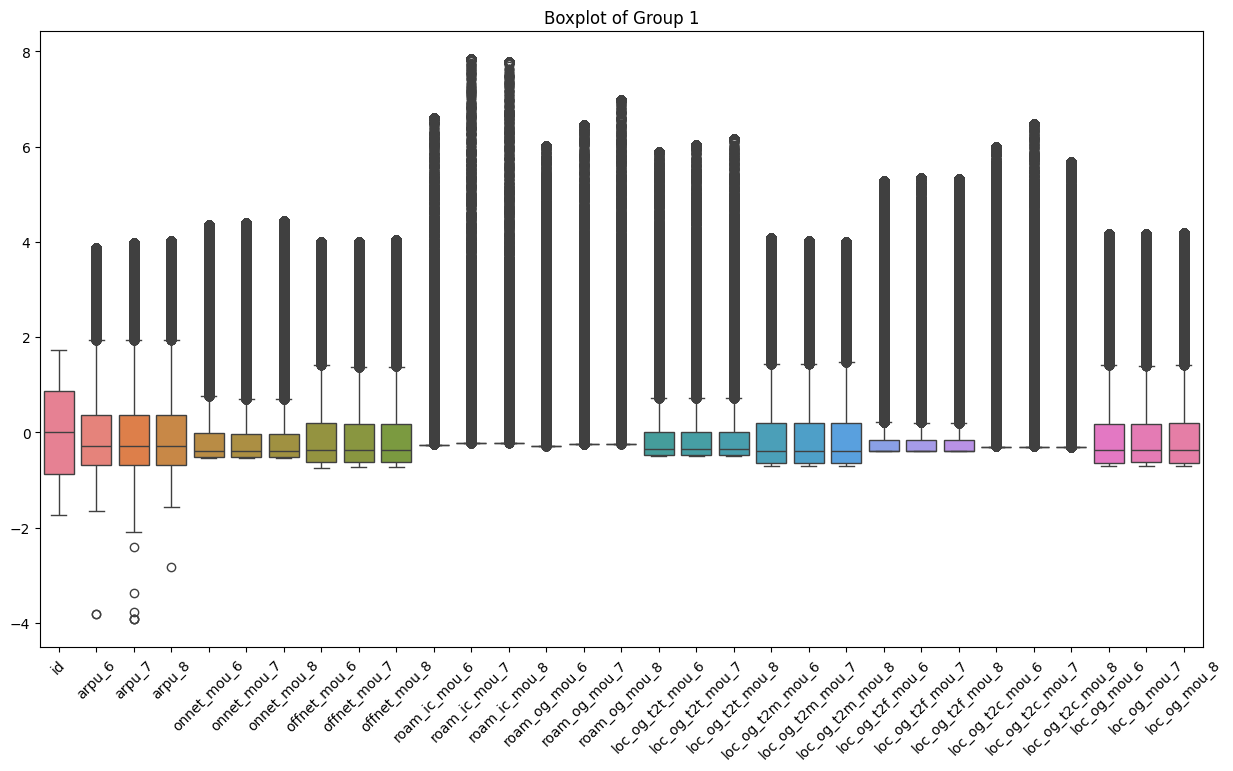

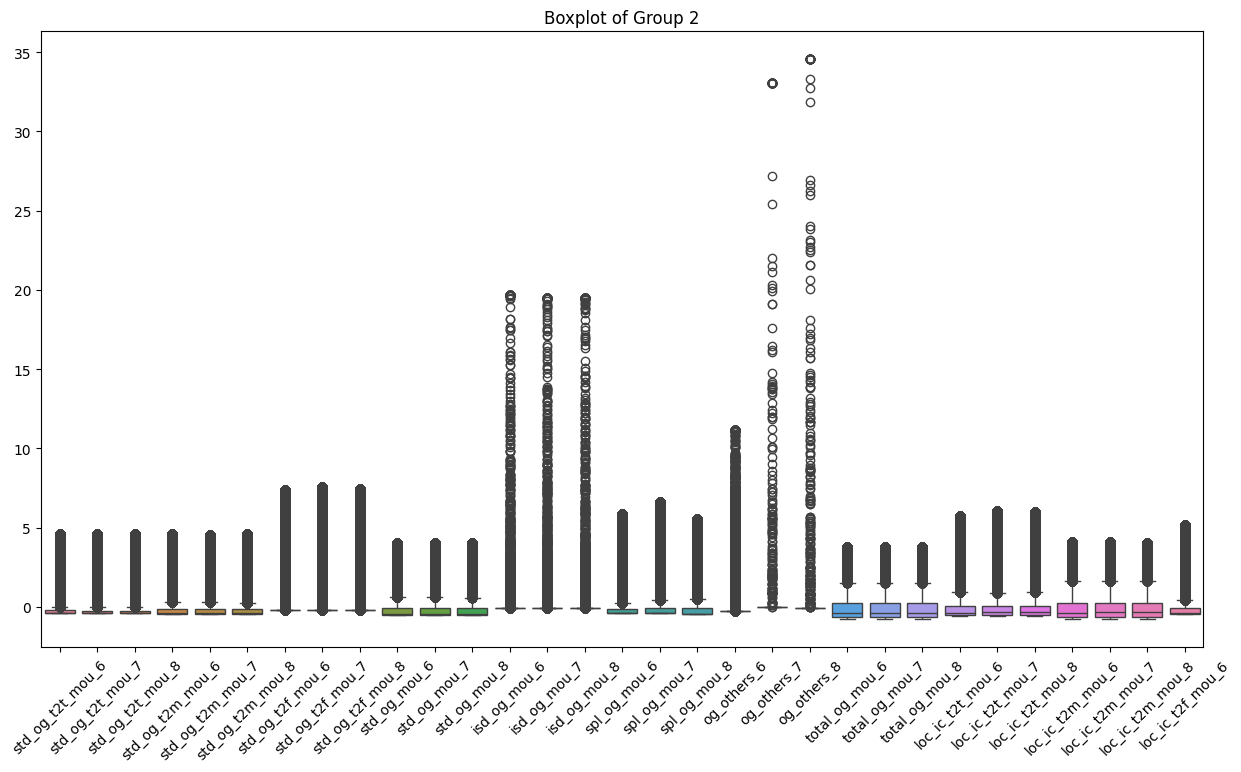

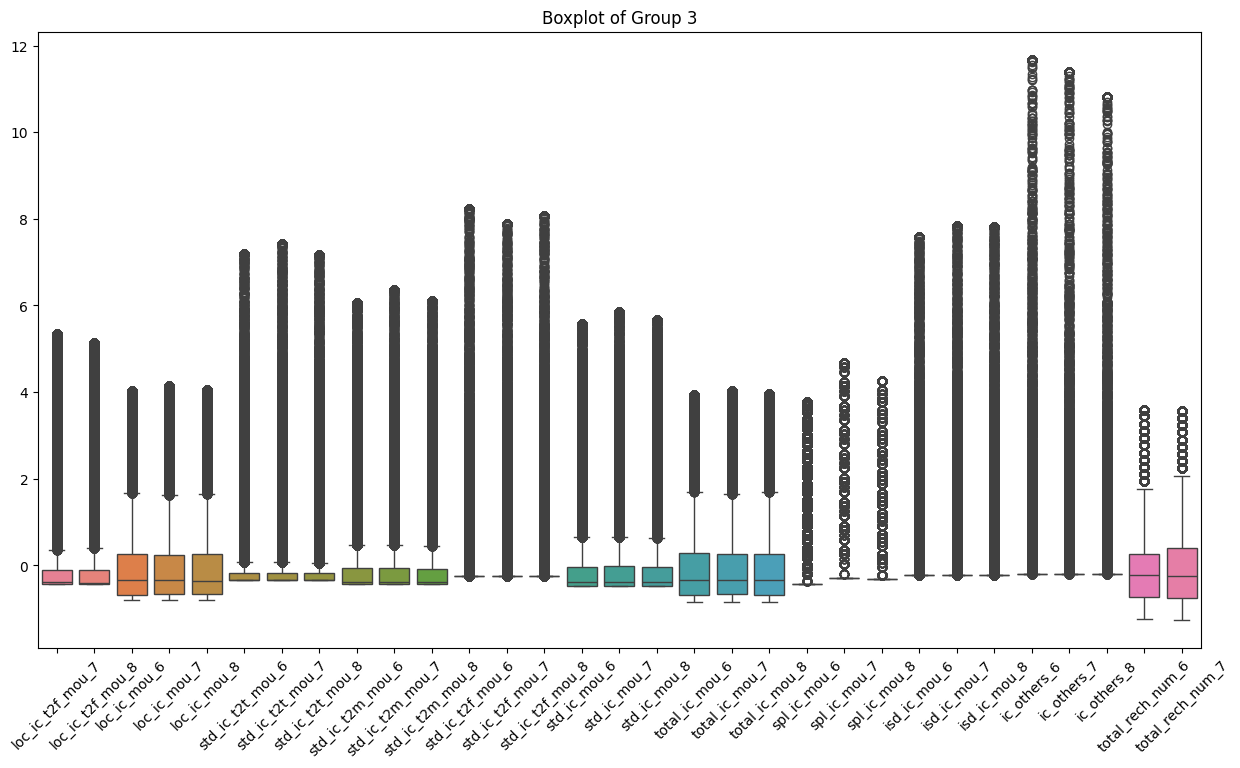

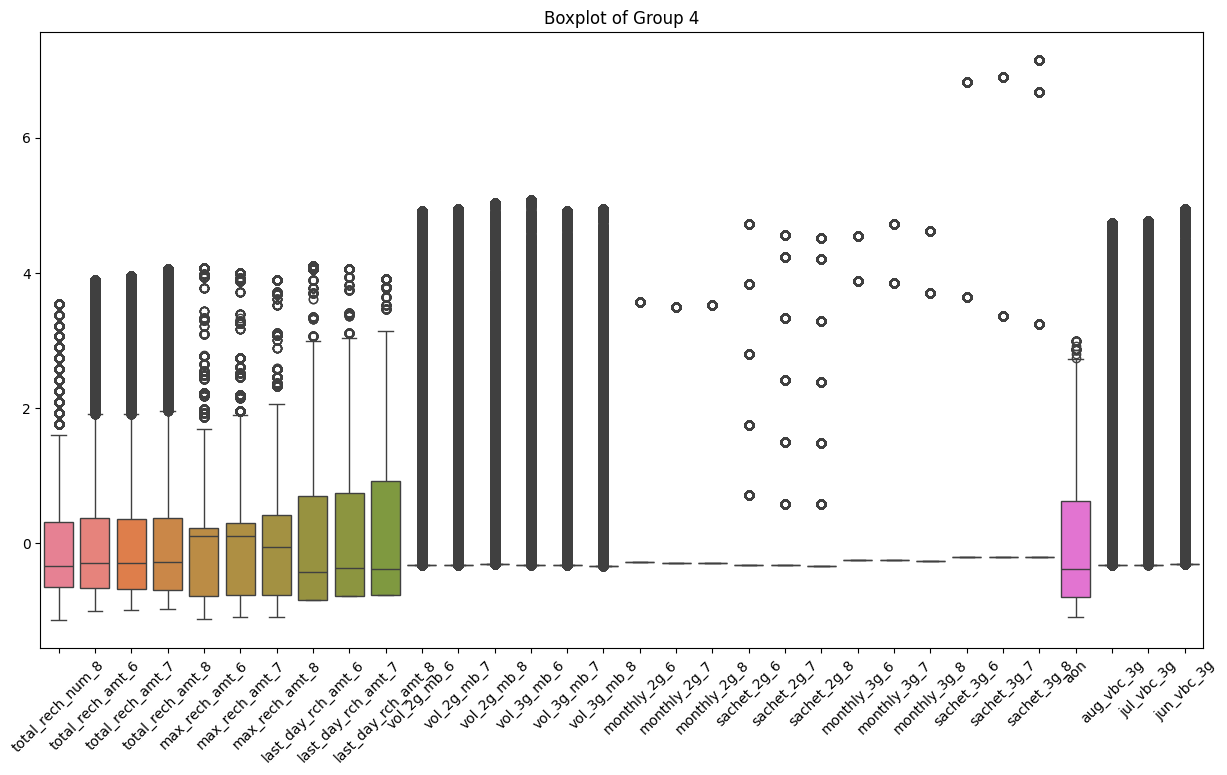

In [264]:
# Convert X_train_filtered2 to a DataFrame with column names from new_vars
X_train_filtered2_df = pd.DataFrame(X_train_filtered2, columns=updated_cols)

# Define the number of groups
num_groups = 4
columns_per_group = len(new_vars) // num_groups

# Create separate boxplots for each group of columns
for i in range(num_groups):
    # Select the subset of columns for this group
    start = i * columns_per_group
    end = (i + 1) * columns_per_group if i != num_groups - 1 else len(new_vars)
    group_columns = new_vars[start:end]
    
    # Create the boxplot for the current group by selecting only the relevant columns
    plt.figure(figsize=(15, 8))
    plt.xticks(rotation=45)
    sns.boxplot(data=X_train_filtered2_df[group_columns])
    plt.title(f"Boxplot of Group {i + 1}")
    plt.show()

<Axes: xlabel='churn_probability', ylabel='Count'>

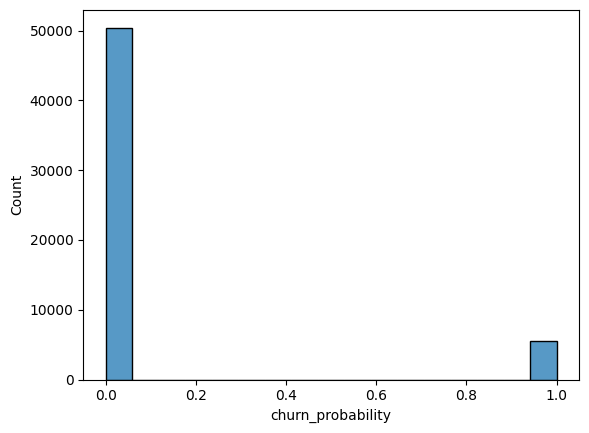

In [265]:
#Distribution for the churn probability
sns.histplot(y_train)

### Selecting Features with RFE

In [267]:
print(X_train_filtered.shape)
print(y_train.shape)


(55999, 129)
(55999,)


In [268]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

logreg = LogisticRegression()
rfe = RFE(estimator=logreg, n_features_to_select=13)  # specify n_features_to_select as a keyword argument
rfe = rfe.fit(X_train_filtered2, y_train)
print(rfe.support_)  # Print the boolean results


[False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False  True False False  True False False
  True False False  True False False  True False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False  True False False
  True False False  True False False  True False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False]


In [269]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('id', False, 106),
 ('arpu_6', True, 1),
 ('arpu_7', False, 13),
 ('arpu_8', False, 24),
 ('onnet_mou_6', False, 64),
 ('onnet_mou_7', False, 109),
 ('onnet_mou_8', False, 25),
 ('offnet_mou_6', False, 22),
 ('offnet_mou_7', False, 102),
 ('offnet_mou_8', False, 11),
 ('roam_ic_mou_6', False, 52),
 ('roam_ic_mou_7', False, 84),
 ('roam_ic_mou_8', False, 108),
 ('roam_og_mou_6', False, 65),
 ('roam_og_mou_7', False, 107),
 ('roam_og_mou_8', False, 12),
 ('loc_og_t2t_mou_6', False, 39),
 ('loc_og_t2t_mou_7', False, 83),
 ('loc_og_t2t_mou_8', False, 7),
 ('loc_og_t2m_mou_6', False, 37),
 ('loc_og_t2m_mou_7', False, 26),
 ('loc_og_t2m_mou_8', False, 2),
 ('loc_og_t2f_mou_6', False, 40),
 ('loc_og_t2f_mou_7', False, 88),
 ('loc_og_t2f_mou_8', False, 111),
 ('loc_og_t2c_mou_6', False, 86),
 ('loc_og_t2c_mou_7', False, 59),
 ('loc_og_t2c_mou_8', False, 44),
 ('loc_og_mou_6', False, 38),
 ('loc_og_mou_7', False, 29),
 ('loc_og_mou_8', False, 6),
 ('std_og_t2t_mou_6', False, 28),
 ('std_og_t2

In [270]:
col = X_train.columns[rfe.support_]

In [271]:
# Variables selected by RFE 
print(col)

Index(['arpu_6', 'std_og_mou_8', 'total_og_mou_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'spl_ic_mou_8',
       'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'vol_2g_mb_8'],
      dtype='object')


##### Assessing the model with StatsModels

In [272]:
# plt.figure(figsize=(10,8))
# sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

In [273]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression(C=1e9)
#logsk.fit(X_train[col], y_train)
logsk.fit(X_train_filtered2, y_train)

LogisticRegression(C=1000000000.0)

In [274]:
#Comparing the model with StatsModels
#logm4 = sm.GLM(y_train,(sm.add_constant(X_train[col])), family = sm.families.Binomial())
import statsmodels.api as sm
logm4 = sm.GLM(y_train,(sm.add_constant(X_train_filtered2)), family = sm.families.Binomial())
modres = logm4.fit()
logm4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                55999
Model:                            GLM   Df Residuals:                    55869
Model Family:                Binomial   Df Model:                          129
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11453.
Date:                Mon, 18 Nov 2024   Deviance:                       22906.
Time:                        19:50:01   Pearson chi2:                 2.01e+07
No. Iterations:                    10   Pseudo R-squ. (CS):             0.2130
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3364      0.051    -84.768      0.000      -4.437      -4.236
x1             0.0037      0.017      0.216      0.829      -0.030       0.037
x2             0.2618      0.070      3.729      0.000       0.124       0.399
x3             0.2464      0.076      3.229      0.001       0.097       0.396
x4             0.3154      0.088      3.576      0.000       0.143       0.488
x5            -0.0540      0.114     -0.473      0.636      -0.278       0.170
x6             0.0188      0.144      0.130      0.896      -0.264       0.302
x7            -0.2427      0.167     -1.449      0.147      -0.571       0.086
x8             0.2123      0.117      1.812      0.070      -0.017       0.442
x9            -0.0186      0.140     -0.132      0.895      -0.294       0.257
x10           -1.0472      0.154     -6.786      0.000      -1.350      -0.745
x11            0.0295      0.027      1.076      0.282      -0.024       0.083
x12            0.0366      0.027      1.375      0.169      -0.016       0.089
x13           -0.0048      0.024     -0.201      0.841      -0.052       0.042
x14            0.0439      0.030      1.466      0.143      -0.015       0.103
x15           -0.0011      0.028     -0.040      0.968      -0.055       0.053
x16            0.2365      0.028      8.476      0.000       0.182       0.291
x17           -0.1241      0.107     -1.158      0.247      -0.334       0.086
x18            0.1699      0.141      1.207      0.228      -0.106       0.446
x19           -0.6999      0.201     -3.476      0.001      -1.094      -0.305
x20           -0.2346      0.152     -1.546      0.122      -0.532       0.063
x21            0.0930      0.201      0.462      0.644      -0.301       0.488
x22           -0.8338      0.273     -3.054      0.002      -1.369      -0.299
x23           -0.0939      0.036     -2.607      0.009      -0.164      -0.023
x24            0.0344      0.043      0.803      0.422      -0.050       0.118
x25           -0.0214      0.051     -0.424      0.671      -0.121       0.078
x26           -0.0269      0.023     -1.197      0.231      -0.071       0.017
x27            0.0558      0.025      2.225      0.026       0.007       0.105
x28            0.0691      0.032      2.166      0.030       0.007       0.132
x29            0.3299      0.236      1.397      0.162      -0.133       0.793
x30           -0.1805      0.307     -0.588      0.556      -0.782       0.421
x31            1.4569      0.415      3.509      0.000       0.643       2.271
x32            0.1671      0.104      1.601      0.109      -0.037       0.372
x33            0.1701      0.136      1.252      0.210      -0.096       0.436
x34           -0.3463      0.167     -2.072      0.038      -0.674      -0.019
x35            0.0626      0.095      0.657      0.511      -0.124       0.249
x3

### we need to drop variables with high p-value and cross-correlation

In [275]:
X_test.describe

<bound method NDFrame.describe of           id    arpu_6    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
20191  20191     0.000   247.810  259.969         0.00       185.23   
25204  25204   713.439  1146.396  560.679        43.76        43.46   
14312  14312   434.925   611.780  944.366        34.28       272.16   
38761  38761   467.477   206.319  109.286        11.59         2.29   
19097  19097   107.988   157.272  313.361        66.26        54.31   
...      ...       ...       ...      ...          ...          ...   
46404  46404   161.714   281.557  130.413         0.00         0.00   
35881  35881    85.661   143.866  157.709         9.43        10.48   
24092  24092  1525.818   817.224  332.607      1008.64       800.53   
66947  66947   285.887   442.539   41.300        66.33       117.29   
50866  50866   360.104   322.290  609.451        14.46        21.28   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  \
20191       270.78          0.00         73.

In [276]:
# X_test[col].shape
# #res = modres.predict(X_test[col])

### Making Predictions with RFE

In [277]:
# Predicted probabilities
y_pred = logsk.predict_proba(X_test_filtered)
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]
# Let's see the head
y_pred_1.head()

1
0  1.405160e-99
1  1.000000e+00
2  0.000000e+00
3  1.000000e+00
4  0.000000e+00

In [278]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

churn_probability
20191                  0
25204                  0
14312                  0
38761                  1
19097                  0

In [279]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'Churn_Prob'})
# Rearranging the columns using reindex
y_pred_final = y_pred_final.reindex(columns=['CustID', 'churn_probability', 'Churn_Prob'])

# Let's see the head of y_pred_final
y_pred_final.head()


CustID  churn_probability    Churn_Prob
0   20191                  0  1.405160e-99
1   25204                  0  1.000000e+00
2   14312                  0  0.000000e+00
3   38761                  1  1.000000e+00
4   19097                  0  0.000000e+00

In [280]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)
# Let's see the head
y_pred_final.head()

CustID  churn_probability    Churn_Prob  predicted
0   20191                  0  1.405160e-99          0
1   25204                  0  1.000000e+00          1
2   14312                  0  0.000000e+00          0
3   38761                  1  1.000000e+00          1
4   19097                  0  0.000000e+00          0

### RFE Model Evaluation

In [281]:
from sklearn import metrics

In [282]:
print(y_pred_final.isnull().sum())


CustID               0
churn_probability    0
Churn_Prob           0
predicted            0
dtype: int64


In [283]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn_probability , y_pred_final.predicted )
confusion

array([[10689,  1759],
       [  859,   693]])

In [284]:
#Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.churn_probability, y_pred_final.predicted)

0.813

In [285]:


# converting to data frame, in order to extract columns
X_train_filtered2_df = pd.DataFrame(X_train_filtered2)


#### Supriyo - could you start PCA here

In [1]:
from sklearn.decomposition import PCA

In [2]:
pca = PCA(random_state=42)

In [77]:
# Display the data types of each column
print(X_train_filtered.dtypes)

id                                 int64
arpu_6                           float64
arpu_7                           float64
arpu_8                           float64
onnet_mou_6                      float64
                                  ...   
jun_vbc_3g                       float64
avg_absolute_change_revenue      float64
avg_percentage_change_revenue    float64
avg_change_onnet_mou             float64
avg_change_offnet_mou            float64
Length: 129, dtype: object


In [78]:
columns_having_null = X_train_filtered.columns[X_train_filtered.isnull().sum()>0]
print(columns_having_null)

Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7',
       'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_

In [79]:
X_train_filtered[columns_having_null] =X_train_filtered[columns_having_null].fillna(0)
print(X_train_filtered.isnull().sum())


id                               0
arpu_6                           0
arpu_7                           0
arpu_8                           0
onnet_mou_6                      0
                                ..
jun_vbc_3g                       0
avg_absolute_change_revenue      0
avg_percentage_change_revenue    0
avg_change_onnet_mou             0
avg_change_offnet_mou            0
Length: 129, dtype: int64


In [80]:
pca.fit(X_train_filtered)

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [42]:
#Segregating the train data for high value customers
## This needs to be done before Scaling ....
X_train_filtered.columns

Index(['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=125)

In [43]:
X_train_filtered.shape

(55999, 125)

In [44]:
X_train_filtered.shape

(55999, 125)

In [45]:
y_train.value_counts()

0    50302
1     5697
Name: churn_probability, dtype: int64

In [46]:
y_test.value_counts()

0    12565
1     1435
Name: churn_probability, dtype: int64

<Axes: xlabel='churn_probability', ylabel='Count'>

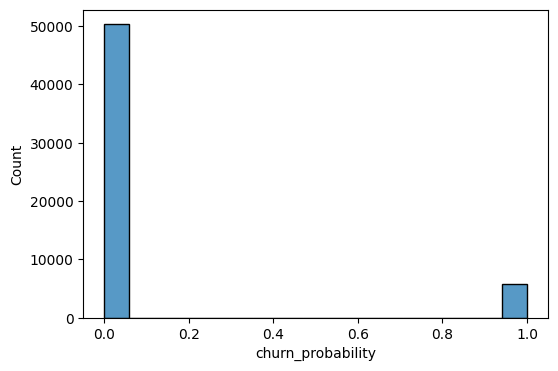

In [47]:
#Distribution for the churn probability
plt.figure(figsize=(6, 4))
sns.histplot(y_train)

In [50]:
from imblearn.over_sampling import SMOTE

In [52]:
smt = SMOTE(random_state=2)
X_train_smote, y_train_smote = smt.fit_resample(X_train_filtered2, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)


(100604, 125)
(100604,)
